# IEEE's Signal Processing Society - Camera Model Identification

## Identify from which camera an image was taken

This is a competition from kaggle.com. The competition closed three months ago and the winning team scored as high as 0.9897.

## Description

Finding footage of a crime caught on tape is an investigator's dream. But even with crystal clear, damning evidence, one critical question always remains–is the footage real?
Today, one way to help authenticate footage is to identify the camera that the image was taken with. Forgeries often require splicing together content from two different cameras. But, unfortunately, the most common way to do this now is using image metadata, which can be easily falsified itself.
This problem is actively studied by several researchers around the world. Many machine learning solutions have been proposed in the past: least-squares estimates of a camera's color demosaicing filters as classification features, co-occurrences of pixel value prediction errors as features that are passed to sophisticated ensemble classifiers, and using CNNs to learn camera model identification features. However, this is a problem yet to be sufficiently solved.
For this competition, the IEEE Signal Processing Society is challenging you to build an algorithm that identifies which camera model captured an image by using traces intrinsically left in the image. Helping to solve this problem would have a big impact on the verification of evidence used in criminal and civil trials and even news reporting.


## How the data was collected

## File descriptions

The data were downloaded manually, since kaggle API failed at 20% of train.zip without reporting an error. The download took several hours.

In [51]:
import os
import numpy as np
import cv2
import random
import sys
import time
import pandas as pd
import keras
from keras.applications import VGG16, ResNet50
from keras.models import Sequential, Model, model_from_json
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow
from matplotlib.image import imread
from tqdm import tqdm
from collections import Counter
import tensorflow as tf

## Read and browse the data

In [21]:
# Where's your train data? Edit this to run on your device.
imagesPath = "D:/Minjino/kojesta/Data Science/Kaggle/train"

# What's in this train folder?
_, dirs, _ = os.walk(imagesPath).__next__()
print("The images are sorted into folders named by the device that took the corresponding photographs.")
print ("See for yourself:")
print(dirs,"\n")
print("There are {} of these folders.\n".format(len(dirs)))

# What do the filenames look like?
print("Checkout some file names:\n")

_, _, tempF = os.walk(imagesPath + "/" + dirs[0]).__next__()
print("In {} we have: {} ... \n".format(dirs[0], tempF[0:4]))
_, _, tempF = os.walk(imagesPath + "/" + dirs[4]).__next__()
print("In {} we have: {} ... \n".format(dirs[4], tempF[0:4]))

print("The images contain their class in their names already. So we can smash them together freely.")


The images are sorted into folders named by the device that took the corresponding photographs.
See for yourself:
['HTC-1-M7', 'iPhone-4s', 'iPhone-6', 'LG-Nexus-5x', 'Motorola-Droid-Maxx', 'Motorola-Nexus-6', 'Motorola-X', 'Samsung-Galaxy-Note3', 'Samsung-Galaxy-S4', 'Sony-NEX-7'] 

There are 10 of these folders.

Checkout some file names:

In HTC-1-M7 we have: ['(HTC-1-M7)1.jpg', '(HTC-1-M7)10.jpg', '(HTC-1-M7)100.jpg', '(HTC-1-M7)101.jpg'] ... 

In Motorola-Droid-Maxx we have: ['(MotoMax)1.jpg', '(MotoMax)10.jpg', '(MotoMax)100.jpg', '(MotoMax)101.jpg'] ... 

The images contain their class in their names already. So we can smash them together freely.


In [22]:
### Smash together freely.
trainPaths = []
noImagesPerFolder=[]
for dir in dirs:
    _, _, tempF = os.walk(imagesPath + "/" + dir).__next__()
    temp = [imagesPath + "/" + dir + "/" + tempf for tempf in tempF]
    noImagesPerFolder.append((dir,len(temp)))
    trainPaths = trainPaths + temp
    
print("So we've got {} of labeled files total.\n".format(len(trainPaths)))
print("That's per folder: \n {} \n".format(noImagesPerFolder))
print("Oh look, the same number of examples for each class. Doesn't get more balanced than this.")

So we've got 2750 of labeled files total.

That's per folder: 
 [('HTC-1-M7', 275), ('iPhone-4s', 275), ('iPhone-6', 275), ('LG-Nexus-5x', 275), ('Motorola-Droid-Maxx', 275), ('Motorola-Nexus-6', 275), ('Motorola-X', 275), ('Samsung-Galaxy-Note3', 275), ('Samsung-Galaxy-S4', 275), ('Sony-NEX-7', 275)] 

Oh look, the same number of examples for each class. Doesn't get more balanced than this.


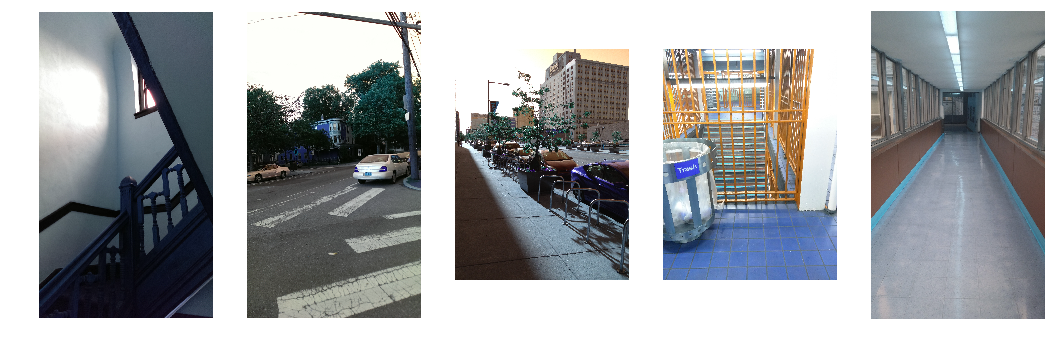

In [4]:
### Check out a few images at pseudo-random

######## OPTIONAL - NEEDN'T RUN ########

randIndices = [2, 77, 391, 1500, 2111]
randImages = [cv2.imread(trainPaths[i]) for i in randIndices]

# get actual colors
randImages2 = [cv2.cvtColor(randImg, cv2.COLOR_BGR2RGB) for randImg in randImages]

# visualize
fig = figure(figsize=(18, 10))
for i in range(0,len(randImages)):
    fig.add_subplot(1,len(randImages), i+1)
    imshow(randImages[i])
    plt.axis("off")
plt.show()

If you take a look at some more images, you'll find that there seem to be no faces, it's mostly some still life and city scenes. This might be a problem in generalizing later on, so hopefully I'll get my hands on more data.

I'd like to see what's up with the image sizes. Let me take a subsamble and check.

In [4]:
# Read a random batch of 100 to check the sizes

######## OPTIONAL - NEEDN'T RUN ########
random.seed(123)
randIndices = random.sample(set(trainPaths),100)
randImages = [cv2.imread(imagePath) for imagePath in tqdm(randIndices)]


100%|████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


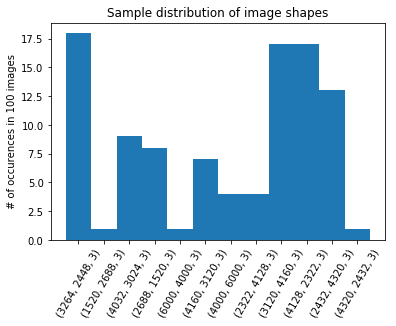

In [6]:
# plot histogram

######## OPTIONAL - NEEDN'T RUN ########

imShapes = [im.shape for im in randImages]  
labels, values = zip(*Counter(imShapes).items())
indexes = np.arange(len(labels))
plt.bar(indexes,values,1)
plt.xticks(indexes, labels, rotation=60)
plt.title("Sample distribution of image shapes")
plt.ylabel("# of occurences in 100 images")
plt.show()

Oh, okay, pretty diverse.
The instructions say that contrary to this, the test data contains only single 512 x 512 pixel blocks cropped from the center of a single image. Some of the test images are altered by resizing, compression or gamma correction. So I'm thinking of applying these transformations on my dataset to make it generalize better. Also augmenting the dataset by rotating, flipping, cropping. 


I have yet no sense whatsoever of how long it could take to train a network on a CPU with this dataset size, so in order to get to a model I can supply as soon as possible, my plan is to use transfer learning and to just resize all my images into 512 x 512 shape, and deal with data augmentation later if I have time. 

In [7]:
# Read in an image from imagePath and resize it to fit the desired shape
def readAndResize(imagePath, shape):
    im = cv2.imread(imagePath)
    imResized = cv2.resize(im, shape, interpolation = cv2.INTER_CUBIC)
    return imResized

Perhaps I could manage to fit such resized images into my not so enviable memory? Let's see.

The new shape of your image is:  (512, 512, 3)


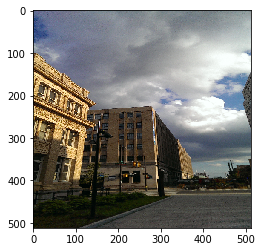

In [16]:
# Test the resize f on  a random image

######## OPTIONAL - NEEDN'T RUN ########

shape = (512, 512)
test = readAndResize(trainPaths[100], shape)
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
print("The new shape of your image is: ", test.shape)
imshow(test)
plt.show()

In [9]:
# How much memory would it take to read all resized data?

######## OPTIONAL - NEEDN'T RUN ########

sizeOfTestImage = round(sys.getsizeof(test)/(1024*1024), 3) # in MB
print("This particular resized image takes up {} MB of your memory".format(sizeOfTestImage))

expectedCummulativeSize = round(sizeOfTestImage*len(trainPaths)/1024, 3) # in GB

print("""Should this be the same for all other resized images,
you can expect the whole dataset of {} images to take up {} GB of memory.
Good luck.""".format(len(trainPaths), expectedCummulativeSize))

This particular resized image takes up 0.75 MB of your memory
Should this be the same for all other resized images,
you can expect the whole dataset of 2750 images to take up 2.014 GB of memory.
Good luck.


But first some more things to do. 
Let's first leave out a validation set. 

In [4]:
# Split the train data into train and validation sets (80:20)
X_train, X_test = train_test_split(trainPaths, test_size = 0.2, random_state = 15)

Great. But what about the labels? There's a few operations we can and should be able to do with them to make them useful in several points of this excercise.

In [23]:
# Extract image names from file paths
def extractLabel(string):
    classLabel = string[string.find('(')+1:string.find(')')]
    return classLabel

# Will need filenames for submission too
def extractName(string):
    fileName = string[string.find('('):]  
    return fileName

# Image filenames contain abbreviations
# These abbreviations correspond to full class names that the submission file should include
def abbrevToFull(abbrevLabel):  
    abbrevToFullClass = {
    'Nex7' : 'Sony-NEX-7',
    'MotoX': 'Motorola-X',
    'MotoNex6': 'Motorola-Nexus-6',
    'MotoMax' : 'Motorola-Droid-Maxx',
    'LG5x' : 'LG-Nexus-5x',
    'iP6': 'iPhone-6',
    'iP4s' : 'iPhone-4s',
    'HTC-1-M7' : 'HTC-1-M7',
    'GalaxyS4': 'Samsung-Galaxy-S4',
    'GalaxyN3' : 'Samsung-Galaxy-Note3'}
    return abbrevToFullClass[abbrevLabel]

# For training a network, string labels won't do.
def convertToInt(label):
    abbrevToInt = {
    'Nex7' : 0,
    'MotoX': 1,
    'MotoNex6': 2,
    'MotoMax' : 3,
    'LG5x' : 4,
    'iP6': 5,
    'iP4s' : 6,
    'HTC-1-M7' : 7,
    'GalaxyS4': 8,
    'GalaxyN3' : 9}
    return abbrevToInt[label]   

def backFromOneHot(one_hot_line):
    integer = np.argmax(one_hot_line)
    intToFullName = {
    0 : 'Sony-NEX-7',
    1 : 'Motorola-X',
    2 : 'Motorola-Nexus-6',
    3 : 'Motorola-Droid-Maxx',
    4 : 'LG-Nexus-5x',
    5 : 'iPhone-6',
    6 : 'iPhone-4s',
    7 : 'HTC-1-M7',
    8 : 'Samsung-Galaxy-S4',
    9 : 'Samsung-Galaxy-Note3'}
    return intToFullName[integer]



In [24]:
# Labels for fit/evaluate model are found in one_hot_train and one_hot_test

Y_train = [extractLabel(path) for path in X_train]
Y_test = [extractLabel(path) for path in X_test]

fnames_train = [extractName(path) for path in X_train]
fnames_test = [extractName(path) for path in X_test]

ints_train = [convertToInt(label) for label in Y_train]
one_hot_train = to_categorical(ints_train)
ints_test = [convertToInt(label) for label in Y_test]
one_hot_test = to_categorical(ints_test)

testFullLabels = [abbrevToFull(label) for label in Y_test]

# See if it looks okay
print("Filenames: \n", fnames_train[0:5])
print("Their class labels: \n", Y_train[0:5])
print("Corresponding class integers: ", ints_train[0:5])
print("And the 1 hots: ", one_hot_train[0:5])

print("Try and reverse: ")
back = [backFromOneHot(x) for x in one_hot_train]
print("Back from hots: ", back[0:5])

Filenames: 
 ['(MotoNex6)30.jpg', '(iP4s)127.jpg', '(Nex7)103.JPG', '(LG5x)58.jpg', '(HTC-1-M7)260.jpg']
Their class labels: 
 ['MotoNex6', 'iP4s', 'Nex7', 'LG5x', 'HTC-1-M7']
Corresponding class integers:  [2, 6, 0, 4, 7]
And the 1 hots:  [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
Try and reverse: 
Back from hots:  ['Motorola-Nexus-6', 'iPhone-4s', 'Sony-NEX-7', 'LG-Nexus-5x', 'HTC-1-M7']


Attempted to create a dataframe with train images, their labels and their file names.
Unfortunately, this still takes a huge blow at my machine's performance, so I'll have to read the images in batches. 

In [11]:
# dfTrain = pd.DataFrame()

# for i in tqdm(range(0,len(X_train))):
#     tempIm = readAndResize(X_train[i],(512,512))
#     temp = pd.Series({'Image': tempIm, 'Class': Y_train[i], 'fileName':fnames_train[i]})
#     dfTrain = dfTrain.append(temp, ignore_index = True)

#### Build upon a pre-trained VGG16

In [24]:
### Version 1.0. Transfer learning from VGG16 trained on imagenet ###

# Flatten, add a relu activated dense layer with 256 units
# Then a softmax layer with output corresponding to 10 classes
# Reading images in batches, resizing to (512,512,3)
# Compiling with adam and mean squared error

inputShape = (512, 512, 3)
conv_base = VGG16(weights = 'imagenet',
                  include_top = False, # not loading the dense layers
                  input_shape = inputShape)
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

In [25]:
# Make the VGG non-trainable
for layer in conv_base.layers:
    layer.trainable = False

In [12]:
# Build upon the VGGnet
inputToVGG = layers.Input(shape=(512, 512, 3),name = 'image_input')
outputOfVGG = conv_base(inputToVGG)
x = layers.Flatten(name = 'Flatten')(outputOfVGG) # Flatten the output of the VGG model
x = layers.Dense(256, activation ='relu', name = 'Fully_Connected')(x) # Add a fully connected layer
# P.s. the choice of 256 neurons is arbitrary, should experiment with this to maximize accuracy
x = layers.Dropout(0.5)(x) # rate of 0.5. also arbitrary 
x = layers.Dense(10, activation = 'softmax')(x) # Add a softmax layer to output 10 classes
m = Model(inputs = inputToVGG, outputs = x)

*Note:* Kept getting error: "softmax() got an unexpected keyword argument 'axis'" 

Was using Keras 2.1.6. Downgraded to 2.1.3 to get it to work. 

In [13]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 512, 512, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
Flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
Fully_Connected (Dense)      (None, 256)               33554688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 48,271,946
Trainable params: 33,557,258
Non-trainable params: 14,714,688
_______________________________________________________

In [14]:
# compile
m.compile(optimizer = 'adam',
         loss = 'mse',
         metrics = ['accuracy'])

In [15]:
# try fitting on a test batch

testBatch = [readAndResize(X_train[i],(512,512)) for i in range(0,10)]
testBatch = np.array(testBatch)
testLabels = one_hot_train[0:10]
print(testBatch.shape)
print(testLabels,len(testLabels))

# m.train_on_batch(testBatch, testLabels)

(10, 512, 512, 3)
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]] 10


I tried training on a batch of only 10 entries, but the browser kept freezing and reporting a time-out error. I thought it might be a problem with using Jupyter, so I ported the code to a .py script. My spirit sank when it said "Python stopped working". I'm gonna try here with an even smaller batch, and see how far and how fast I can go. Bear with me.

In [16]:
# increment mini batch size and see what you can train at a time

###### TRAINING!!! #####

for batchSize in range(2,9):
    tic = time.time()
    testBatch = [readAndResize(X_train[i],(512,512)) for i in range(0,batchSize)]
    testBatch = np.array(testBatch)
    testLabels = one_hot_train[0:batchSize]
    m.train_on_batch(testBatch, testLabels)
    toc = time.time()
    print("I can do this batch size of {} in {}s".format(batchSize,toc-tic))

I can do this batch size of 2 in 9.131522417068481s
I can do this batch size of 3 in 10.186582565307617s
I can do this batch size of 4 in 14.400823593139648s
I can do this batch size of 5 in 22.229271411895752s
I can do this batch size of 6 in 229.19610929489136s
I can do this batch size of 7 in 472.8650462627411s
I can do this batch size of 8 in 596.7771337032318s


In [ ]:
# # more?
# # increment mini batch size
# for batchSize in range(10,12):
#     tic = time.time()
#     testBatch = [readAndResize(X_train[i],(512,512)) for i in range(0,batchSize)]
#     testBatch = np.array(testBatch)
#     testLabels = one_hot_train[0:batchSize]
#     m.train_on_batch(testBatch, testLabels)
#     toc = time.time()
#     print("I can do this batch size of {} in {}s".format(batchSize,toc-tic))


With the batch size of 10, the kernel died once again.
If I settle for the size of 8, with the training set having 2200 entries, this is gonna make 275 iterations per epoch.
...:
...Which is 597s * 275/3600 = 45h. :(
I'll have to dumb it down even more and reduce the number of neurons in the dense layer. Let's see how that fares.

In [26]:
### Version 1.1. Transfer learning from VGG16 trained on imagenet ###

# Flatten, add a relu activated dense layer with 128 units
# Then a softmax layer with output corresponding to 10 classes
# Reading images in batches, resizing to (512,512,3)
# Compiling with adam and mean squared error

inputToVGG2 = layers.Input(shape=(512, 512, 3),name = 'image_input')
outputOfVGG2 = conv_base(inputToVGG2)
x2 = layers.Flatten(name = 'Flatten')(outputOfVGG2) # Flatten the output of the VGG model
x2 = layers.Dense(128, activation ='relu', name = 'Fully_Connected')(x2) # Add a fully connected layer
# P.s. the choice of 256 neurons is arbitrary, should experiment with this to maximize accuracy
x2 = layers.Dropout(0.5)(x2) # rate of 0.5. also arbitrary 
x2 = layers.Dense(10, activation = 'softmax')(x2) # Add a softmax layer to output 10 classes
m2 = Model(inputs = inputToVGG2, outputs = x2)
m2.compile(optimizer = 'adam',
         loss = 'mse',
         metrics = ['accuracy'])

In [15]:
# increment mini batch size ver 1.1.0

def testTrainTimes(maxSize, model,resizeShape):
    for batchSize in range(2,maxSize):
        tic = time.time()
        testBatch = [readAndResize(X_train[i],resizeShape) for i in range(0,batchSize)]
        testBatch = np.array(testBatch)
        testLabels = one_hot_train[0:batchSize]
        model.train_on_batch(testBatch, testLabels)
        toc = time.time()
        print("I can do this batch size of {} in {}s".format(batchSize,toc-tic))
    return

In [ ]:
##### !!!! TRAINING!!!! ######

testTrainTimes(10,m2,(512,512))

I can do this batch size of 2 in 8.063461065292358s
I can do this batch size of 3 in 10.016572952270508s
I can do this batch size of 4 in 13.988800048828125s
I can do this batch size of 5 in 89.83513832092285s
I can do this batch size of 6 in 306.2165148258209s
I can do this batch size of 7 in 476.29424238204956s
I can do this batch size of 8 in 580.7112147808075s


Well this is not exactly faster. The draggy pace likely stems not from the number of parameters to fit, but from reading the images. Is it faster if I reduce the image size further?

In [115]:
### Version 1.2. Transfer learning from VGG16 trained on imagenet ###

# Flatten, add a relu activated dense layer with 256 units
# Then a softmax layer with output corresponding to 10 classes
# Reading images in batches, resizing to (256,256,3)
# Compiling with adam and mean squared error


inputShape = (256, 256, 3)
conv_base3 = VGG16(weights = 'imagenet',
                  include_top = False, # not loading the dense layers
                  input_shape = inputShape)
for layer in conv_base3.layers:
    layer.trainable = False

inputToVGG3 = layers.Input(shape=inputShape,name = 'image_input')
outputOfVGG3 = conv_base3(inputToVGG3)
x3 = layers.Flatten(name = 'Flatten')(outputOfVGG3) # Flatten the output of the VGG model
x3 = layers.Dense(256, activation ='relu', name = 'Fully_Connected')(x3) # Add a fully connected layer
# P.s. the choice of 256 neurons is arbitrary, should experiment with this to maximize accuracy
x3 = layers.Dropout(0.5)(x3) # rate of 0.5. also arbitrary 
x3 = layers.Dense(10, activation = 'softmax')(x3) # Add a softmax layer to output 10 classes
m3 = Model(inputs = inputToVGG3, outputs = x3)
m3.compile(optimizer = 'adam',
         loss = 'mse',
         metrics = ['accuracy'])

In [18]:
######### !!!! TRAINING !!!! ################

testTrainTimes(11,m3,(256,256))


I can do this batch size of 2 in 4.305246114730835s
I can do this batch size of 3 in 5.036288261413574s
I can do this batch size of 4 in 4.934282302856445s
I can do this batch size of 5 in 5.644322872161865s
I can do this batch size of 6 in 6.150351524353027s
I can do this batch size of 7 in 8.539488315582275s
I can do this batch size of 8 in 8.910509824752808s
I can do this batch size of 9 in 12.28470253944397s
I can do this batch size of 10 in 73.97923135757446s


Now this is much better! (Although the computer still went unresponsive for a while at batch size = 10)
With the batch of 8 done in 9s, I could pass all data once in less than an hour. Worth a try!

In [7]:
def trainForSomeEpochs(model, X_train, epochs):
    # Split the training set into folds (batches)

    ind = [x for x in range(0,len(X_train))]
    kf = KFold(n_splits=275,random_state=15)
    folds = kf.split(ind) # it's a generator!

    # Train n epochs reading and training on one batch only at a time

    #########################################
    ######## !!!!!!!! TRAINING !!!!! ########
    #########################################

    for epoch in range(0,epochs):
        batchNo = 0
        for _, testIndices in tqdm(folds):
            testBatch = [readAndResize(X_train[i],(256,256)) for i in testIndices]
            testBatch = np.array(testBatch)
            testLabels = one_hot_train[testIndices]
            model.train_on_batch(testBatch, testLabels)
            batchNo+=1 
            print(batchNo, "Done with one batch! Can I haz cookie?")
        print(epoch, "Done with one epoch!")
    return

In [25]:
# Save the model to json
def saveModel(model, fileName):
    # filename without extension
    model_json = model.to_json()
    with open(fileName+".json", "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(fileName + ".h5")
    print("Saved model to disk")

In [14]:
######### !!!! TRAINING !!!! ################
trainForSomeEpochs(m3,X_train,1)
saveModel(m3,"model3")



0it [00:00, ?it/s]

1 Done with one batch! Can I haz cookie?



1it [00:09,  9.86s/it]

2 Done with one batch! Can I haz cookie?



2it [00:20, 10.09s/it]

3 Done with one batch! Can I haz cookie?



3it [00:29,  9.75s/it]

4 Done with one batch! Can I haz cookie?



4it [00:40, 10.01s/it]

5 Done with one batch! Can I haz cookie?



5it [00:50, 10.05s/it]

6 Done with one batch! Can I haz cookie?



6it [00:59,  9.91s/it]

7 Done with one batch! Can I haz cookie?



7it [01:09,  9.89s/it]

8 Done with one batch! Can I haz cookie?



8it [01:19,  9.88s/it]

9 Done with one batch! Can I haz cookie?



9it [01:30, 10.00s/it]

10 Done with one batch! Can I haz cookie?



10it [01:40, 10.03s/it]

11 Done with one batch! Can I haz cookie?



11it [01:50, 10.04s/it]

12 Done with one batch! Can I haz cookie?



12it [02:00, 10.03s/it]

13 Done with one batch! Can I haz cookie?



13it [02:10, 10.04s/it]

14 Done with one batch! Can I haz cookie?



14it [02:21, 10.10s/it]

15 Done with one batch! Can I haz cookie?



15it [02:31, 10.13s/it]

16 Done with one batch! Can I haz cookie?



16it [02:42, 10.17s/it]

17 Done with one batch! Can I haz cookie?



17it [02:52, 10.17s/it]

18 Done with one batch! Can I haz cookie?



18it [03:02, 10.16s/it]

19 Done with one batch! Can I haz cookie?



19it [03:13, 10.16s/it]

20 Done with one batch! Can I haz cookie?



20it [03:23, 10.18s/it]

21 Done with one batch! Can I haz cookie?



21it [03:33, 10.17s/it]

22 Done with one batch! Can I haz cookie?



22it [03:43, 10.15s/it]

23 Done with one batch! Can I haz cookie?



23it [03:54, 10.18s/it]

24 Done with one batch! Can I haz cookie?



24it [04:03, 10.15s/it]

25 Done with one batch! Can I haz cookie?



25it [04:13, 10.15s/it]

26 Done with one batch! Can I haz cookie?



26it [04:23, 10.14s/it]

27 Done with one batch! Can I haz cookie?



27it [04:33, 10.13s/it]

28 Done with one batch! Can I haz cookie?



28it [04:43, 10.12s/it]

29 Done with one batch! Can I haz cookie?



29it [04:53, 10.12s/it]

30 Done with one batch! Can I haz cookie?



30it [05:03, 10.13s/it]

31 Done with one batch! Can I haz cookie?



31it [05:14, 10.13s/it]

32 Done with one batch! Can I haz cookie?



32it [05:24, 10.14s/it]

33 Done with one batch! Can I haz cookie?



33it [05:34, 10.14s/it]

34 Done with one batch! Can I haz cookie?



34it [05:44, 10.14s/it]

35 Done with one batch! Can I haz cookie?



35it [05:54, 10.13s/it]

36 Done with one batch! Can I haz cookie?



36it [06:04, 10.11s/it]

37 Done with one batch! Can I haz cookie?



37it [06:14, 10.11s/it]

38 Done with one batch! Can I haz cookie?



38it [06:23, 10.10s/it]

39 Done with one batch! Can I haz cookie?



39it [06:34, 10.11s/it]

40 Done with one batch! Can I haz cookie?



40it [06:44, 10.11s/it]

41 Done with one batch! Can I haz cookie?



41it [06:54, 10.11s/it]

42 Done with one batch! Can I haz cookie?



42it [07:06, 10.16s/it]

43 Done with one batch! Can I haz cookie?



43it [07:16, 10.14s/it]

44 Done with one batch! Can I haz cookie?



44it [07:26, 10.14s/it]

45 Done with one batch! Can I haz cookie?



45it [07:35, 10.13s/it]

46 Done with one batch! Can I haz cookie?



46it [07:45, 10.12s/it]

47 Done with one batch! Can I haz cookie?



47it [07:56, 10.15s/it]

48 Done with one batch! Can I haz cookie?



48it [08:06, 10.14s/it]

49 Done with one batch! Can I haz cookie?



49it [08:16, 10.13s/it]

50 Done with one batch! Can I haz cookie?



50it [08:27, 10.14s/it]

51 Done with one batch! Can I haz cookie?



51it [08:36, 10.12s/it]

52 Done with one batch! Can I haz cookie?



52it [08:46, 10.13s/it]

53 Done with one batch! Can I haz cookie?



53it [08:56, 10.12s/it]

54 Done with one batch! Can I haz cookie?



54it [09:07, 10.15s/it]

55 Done with one batch! Can I haz cookie?



55it [09:18, 10.16s/it]

56 Done with one batch! Can I haz cookie?



56it [09:28, 10.15s/it]

57 Done with one batch! Can I haz cookie?



57it [09:37, 10.14s/it]

58 Done with one batch! Can I haz cookie?



58it [09:47, 10.13s/it]

59 Done with one batch! Can I haz cookie?



59it [09:57, 10.13s/it]

60 Done with one batch! Can I haz cookie?



60it [10:08, 10.14s/it]

61 Done with one batch! Can I haz cookie?



61it [10:18, 10.14s/it]

62 Done with one batch! Can I haz cookie?



62it [10:28, 10.14s/it]

63 Done with one batch! Can I haz cookie?



63it [10:38, 10.14s/it]

64 Done with one batch! Can I haz cookie?



64it [10:48, 10.13s/it]

65 Done with one batch! Can I haz cookie?



65it [10:58, 10.13s/it]

66 Done with one batch! Can I haz cookie?



66it [11:08, 10.13s/it]

67 Done with one batch! Can I haz cookie?



67it [11:17, 10.12s/it]

68 Done with one batch! Can I haz cookie?



68it [11:27, 10.11s/it]

69 Done with one batch! Can I haz cookie?



69it [11:37, 10.11s/it]

70 Done with one batch! Can I haz cookie?



70it [11:47, 10.10s/it]

71 Done with one batch! Can I haz cookie?



71it [11:57, 10.10s/it]

72 Done with one batch! Can I haz cookie?



72it [12:07, 10.10s/it]

73 Done with one batch! Can I haz cookie?



73it [12:17, 10.10s/it]

74 Done with one batch! Can I haz cookie?



74it [12:26, 10.09s/it]

75 Done with one batch! Can I haz cookie?



75it [12:37, 10.10s/it]

76 Done with one batch! Can I haz cookie?



76it [12:46, 10.09s/it]

77 Done with one batch! Can I haz cookie?



77it [12:56, 10.09s/it]

78 Done with one batch! Can I haz cookie?



78it [13:07, 10.09s/it]

79 Done with one batch! Can I haz cookie?



79it [13:18, 10.10s/it]

80 Done with one batch! Can I haz cookie?



80it [13:27, 10.10s/it]

81 Done with one batch! Can I haz cookie?



81it [13:38, 10.10s/it]

82 Done with one batch! Can I haz cookie?



82it [13:47, 10.09s/it]

83 Done with one batch! Can I haz cookie?



83it [13:57, 10.09s/it]

84 Done with one batch! Can I haz cookie?



84it [14:06, 10.08s/it]

85 Done with one batch! Can I haz cookie?



85it [14:17, 10.08s/it]

86 Done with one batch! Can I haz cookie?



86it [14:26, 10.08s/it]

87 Done with one batch! Can I haz cookie?



87it [14:37, 10.08s/it]

88 Done with one batch! Can I haz cookie?



88it [14:47, 10.08s/it]

89 Done with one batch! Can I haz cookie?



89it [14:56, 10.07s/it]

90 Done with one batch! Can I haz cookie?



90it [15:06, 10.08s/it]

91 Done with one batch! Can I haz cookie?



91it [15:16, 10.08s/it]

92 Done with one batch! Can I haz cookie?



92it [15:26, 10.07s/it]

93 Done with one batch! Can I haz cookie?



93it [15:37, 10.08s/it]

94 Done with one batch! Can I haz cookie?



94it [15:47, 10.08s/it]

95 Done with one batch! Can I haz cookie?



95it [15:56, 10.07s/it]

96 Done with one batch! Can I haz cookie?



96it [16:07, 10.07s/it]

97 Done with one batch! Can I haz cookie?



97it [16:16, 10.07s/it]

98 Done with one batch! Can I haz cookie?



98it [16:27, 10.07s/it]

99 Done with one batch! Can I haz cookie?



99it [16:36, 10.07s/it]

100 Done with one batch! Can I haz cookie?



100it [16:46, 10.06s/it]

101 Done with one batch! Can I haz cookie?



101it [16:56, 10.06s/it]

102 Done with one batch! Can I haz cookie?



102it [17:06, 10.07s/it]

103 Done with one batch! Can I haz cookie?



103it [17:17, 10.07s/it]

104 Done with one batch! Can I haz cookie?



104it [17:27, 10.07s/it]

105 Done with one batch! Can I haz cookie?



105it [17:36, 10.07s/it]

106 Done with one batch! Can I haz cookie?



106it [17:47, 10.07s/it]

107 Done with one batch! Can I haz cookie?



107it [17:57, 10.07s/it]

108 Done with one batch! Can I haz cookie?



108it [18:07, 10.07s/it]

109 Done with one batch! Can I haz cookie?



109it [18:16, 10.06s/it]

110 Done with one batch! Can I haz cookie?



110it [18:27, 10.07s/it]

111 Done with one batch! Can I haz cookie?



111it [18:36, 10.06s/it]

112 Done with one batch! Can I haz cookie?



112it [18:46, 10.06s/it]

113 Done with one batch! Can I haz cookie?



113it [18:55, 10.05s/it]

114 Done with one batch! Can I haz cookie?



114it [19:05, 10.05s/it]

115 Done with one batch! Can I haz cookie?



115it [19:15, 10.05s/it]

116 Done with one batch! Can I haz cookie?



116it [19:25, 10.05s/it]

117 Done with one batch! Can I haz cookie?



117it [19:36, 10.05s/it]

118 Done with one batch! Can I haz cookie?



118it [19:46, 10.05s/it]

119 Done with one batch! Can I haz cookie?



119it [19:56, 10.05s/it]

120 Done with one batch! Can I haz cookie?



120it [20:06, 10.05s/it]

121 Done with one batch! Can I haz cookie?



121it [20:17, 10.06s/it]

122 Done with one batch! Can I haz cookie?



122it [20:26, 10.06s/it]

123 Done with one batch! Can I haz cookie?



123it [20:36, 10.06s/it]

124 Done with one batch! Can I haz cookie?



124it [20:46, 10.05s/it]

125 Done with one batch! Can I haz cookie?



125it [20:56, 10.05s/it]

126 Done with one batch! Can I haz cookie?



126it [21:06, 10.05s/it]

127 Done with one batch! Can I haz cookie?



127it [21:16, 10.05s/it]

128 Done with one batch! Can I haz cookie?



128it [21:26, 10.05s/it]

129 Done with one batch! Can I haz cookie?



129it [21:35, 10.05s/it]

130 Done with one batch! Can I haz cookie?



130it [21:46, 10.05s/it]

131 Done with one batch! Can I haz cookie?



131it [21:56, 10.05s/it]

132 Done with one batch! Can I haz cookie?



132it [22:06, 10.05s/it]

133 Done with one batch! Can I haz cookie?



133it [22:16, 10.05s/it]

134 Done with one batch! Can I haz cookie?



134it [22:26, 10.05s/it]

135 Done with one batch! Can I haz cookie?



135it [22:36, 10.05s/it]

136 Done with one batch! Can I haz cookie?



136it [22:46, 10.05s/it]

137 Done with one batch! Can I haz cookie?



137it [22:57, 10.05s/it]

138 Done with one batch! Can I haz cookie?



138it [23:07, 10.06s/it]

139 Done with one batch! Can I haz cookie?



139it [23:17, 10.05s/it]

140 Done with one batch! Can I haz cookie?



140it [23:28, 10.06s/it]

141 Done with one batch! Can I haz cookie?



141it [23:37, 10.05s/it]

142 Done with one batch! Can I haz cookie?



142it [23:48, 10.06s/it]

143 Done with one batch! Can I haz cookie?



143it [23:57, 10.06s/it]

144 Done with one batch! Can I haz cookie?



144it [24:08, 10.06s/it]

145 Done with one batch! Can I haz cookie?



145it [24:17, 10.05s/it]

146 Done with one batch! Can I haz cookie?



146it [24:28, 10.06s/it]

147 Done with one batch! Can I haz cookie?



147it [24:38, 10.06s/it]

148 Done with one batch! Can I haz cookie?



148it [24:47, 10.05s/it]

149 Done with one batch! Can I haz cookie?



149it [24:58, 10.06s/it]

150 Done with one batch! Can I haz cookie?



150it [25:08, 10.06s/it]

151 Done with one batch! Can I haz cookie?



151it [25:19, 10.06s/it]

152 Done with one batch! Can I haz cookie?



152it [25:29, 10.06s/it]

153 Done with one batch! Can I haz cookie?



153it [25:40, 10.07s/it]

154 Done with one batch! Can I haz cookie?



154it [25:50, 10.07s/it]

155 Done with one batch! Can I haz cookie?



155it [26:00, 10.07s/it]

156 Done with one batch! Can I haz cookie?



156it [26:10, 10.07s/it]

157 Done with one batch! Can I haz cookie?



157it [26:20, 10.06s/it]

158 Done with one batch! Can I haz cookie?



158it [26:30, 10.07s/it]

159 Done with one batch! Can I haz cookie?



159it [26:41, 10.07s/it]

160 Done with one batch! Can I haz cookie?



160it [26:51, 10.07s/it]

161 Done with one batch! Can I haz cookie?



161it [27:02, 10.08s/it]

162 Done with one batch! Can I haz cookie?



162it [27:12, 10.08s/it]

163 Done with one batch! Can I haz cookie?



163it [27:22, 10.08s/it]

164 Done with one batch! Can I haz cookie?



164it [27:33, 10.08s/it]

165 Done with one batch! Can I haz cookie?



165it [27:43, 10.08s/it]

166 Done with one batch! Can I haz cookie?



166it [27:53, 10.08s/it]

167 Done with one batch! Can I haz cookie?



167it [28:03, 10.08s/it]

168 Done with one batch! Can I haz cookie?



168it [28:14, 10.08s/it]

169 Done with one batch! Can I haz cookie?



169it [28:24, 10.08s/it]

170 Done with one batch! Can I haz cookie?



170it [28:33, 10.08s/it]

171 Done with one batch! Can I haz cookie?



171it [28:44, 10.09s/it]

172 Done with one batch! Can I haz cookie?



172it [28:54, 10.09s/it]

173 Done with one batch! Can I haz cookie?



173it [29:04, 10.08s/it]

174 Done with one batch! Can I haz cookie?



174it [29:15, 10.09s/it]

175 Done with one batch! Can I haz cookie?



175it [29:25, 10.09s/it]

176 Done with one batch! Can I haz cookie?



176it [29:36, 10.10s/it]

177 Done with one batch! Can I haz cookie?



177it [29:47, 10.10s/it]

178 Done with one batch! Can I haz cookie?



178it [29:57, 10.10s/it]

179 Done with one batch! Can I haz cookie?



179it [30:08, 10.10s/it]

180 Done with one batch! Can I haz cookie?



180it [30:20, 10.11s/it]

181 Done with one batch! Can I haz cookie?



181it [30:34, 10.13s/it]

182 Done with one batch! Can I haz cookie?



182it [30:44, 10.14s/it]

183 Done with one batch! Can I haz cookie?



183it [30:56, 10.15s/it]

184 Done with one batch! Can I haz cookie?



184it [31:07, 10.15s/it]

185 Done with one batch! Can I haz cookie?



185it [31:17, 10.15s/it]

186 Done with one batch! Can I haz cookie?



186it [31:28, 10.15s/it]

187 Done with one batch! Can I haz cookie?



187it [31:38, 10.15s/it]

188 Done with one batch! Can I haz cookie?



188it [31:48, 10.15s/it]

189 Done with one batch! Can I haz cookie?



189it [32:00, 10.16s/it]

190 Done with one batch! Can I haz cookie?



190it [32:10, 10.16s/it]

191 Done with one batch! Can I haz cookie?



191it [32:22, 10.17s/it]

192 Done with one batch! Can I haz cookie?



192it [32:31, 10.17s/it]

193 Done with one batch! Can I haz cookie?



193it [32:42, 10.17s/it]

194 Done with one batch! Can I haz cookie?



194it [32:52, 10.17s/it]

195 Done with one batch! Can I haz cookie?



195it [33:03, 10.17s/it]

196 Done with one batch! Can I haz cookie?



196it [33:14, 10.18s/it]

197 Done with one batch! Can I haz cookie?



197it [33:24, 10.18s/it]

198 Done with one batch! Can I haz cookie?



198it [33:34, 10.18s/it]

199 Done with one batch! Can I haz cookie?



199it [33:45, 10.18s/it]

200 Done with one batch! Can I haz cookie?



200it [33:54, 10.17s/it]

201 Done with one batch! Can I haz cookie?



201it [34:04, 10.17s/it]

202 Done with one batch! Can I haz cookie?



202it [34:14, 10.17s/it]

203 Done with one batch! Can I haz cookie?



203it [34:24, 10.17s/it]

204 Done with one batch! Can I haz cookie?



204it [34:34, 10.17s/it]

205 Done with one batch! Can I haz cookie?



205it [34:44, 10.17s/it]

206 Done with one batch! Can I haz cookie?



206it [34:54, 10.17s/it]

207 Done with one batch! Can I haz cookie?



207it [35:05, 10.17s/it]

208 Done with one batch! Can I haz cookie?



208it [35:16, 10.17s/it]

209 Done with one batch! Can I haz cookie?



209it [35:26, 10.17s/it]

210 Done with one batch! Can I haz cookie?



210it [35:36, 10.17s/it]

211 Done with one batch! Can I haz cookie?



211it [35:46, 10.17s/it]

212 Done with one batch! Can I haz cookie?



212it [35:56, 10.17s/it]

213 Done with one batch! Can I haz cookie?



213it [36:06, 10.17s/it]

214 Done with one batch! Can I haz cookie?



214it [36:16, 10.17s/it]

215 Done with one batch! Can I haz cookie?



215it [36:26, 10.17s/it]

216 Done with one batch! Can I haz cookie?



216it [36:36, 10.17s/it]

217 Done with one batch! Can I haz cookie?



217it [36:46, 10.17s/it]

218 Done with one batch! Can I haz cookie?



218it [36:57, 10.17s/it]

219 Done with one batch! Can I haz cookie?



219it [37:07, 10.17s/it]

220 Done with one batch! Can I haz cookie?



220it [37:17, 10.17s/it]

221 Done with one batch! Can I haz cookie?



221it [37:27, 10.17s/it]

222 Done with one batch! Can I haz cookie?



222it [37:38, 10.17s/it]

223 Done with one batch! Can I haz cookie?



223it [37:48, 10.17s/it]

224 Done with one batch! Can I haz cookie?



224it [37:59, 10.18s/it]

225 Done with one batch! Can I haz cookie?



225it [38:09, 10.17s/it]

226 Done with one batch! Can I haz cookie?



226it [38:19, 10.17s/it]

227 Done with one batch! Can I haz cookie?



227it [38:29, 10.17s/it]

228 Done with one batch! Can I haz cookie?



228it [38:39, 10.17s/it]

229 Done with one batch! Can I haz cookie?



229it [38:50, 10.17s/it]

230 Done with one batch! Can I haz cookie?



230it [39:00, 10.18s/it]

231 Done with one batch! Can I haz cookie?



231it [39:10, 10.18s/it]

232 Done with one batch! Can I haz cookie?



232it [39:20, 10.17s/it]

233 Done with one batch! Can I haz cookie?



233it [39:30, 10.17s/it]

234 Done with one batch! Can I haz cookie?



234it [39:40, 10.17s/it]

235 Done with one batch! Can I haz cookie?



235it [39:50, 10.17s/it]

236 Done with one batch! Can I haz cookie?



236it [40:00, 10.17s/it]

237 Done with one batch! Can I haz cookie?



237it [40:10, 10.17s/it]

238 Done with one batch! Can I haz cookie?



238it [40:21, 10.18s/it]

239 Done with one batch! Can I haz cookie?



239it [40:31, 10.17s/it]

240 Done with one batch! Can I haz cookie?



240it [40:41, 10.17s/it]

241 Done with one batch! Can I haz cookie?



241it [40:51, 10.17s/it]

242 Done with one batch! Can I haz cookie?



242it [41:01, 10.17s/it]

243 Done with one batch! Can I haz cookie?



243it [41:11, 10.17s/it]

244 Done with one batch! Can I haz cookie?



244it [41:21, 10.17s/it]

245 Done with one batch! Can I haz cookie?



245it [41:31, 10.17s/it]

246 Done with one batch! Can I haz cookie?



246it [41:42, 10.17s/it]

247 Done with one batch! Can I haz cookie?



247it [41:51, 10.17s/it]

248 Done with one batch! Can I haz cookie?



248it [42:01, 10.17s/it]

249 Done with one batch! Can I haz cookie?



249it [42:12, 10.17s/it]

250 Done with one batch! Can I haz cookie?



250it [42:22, 10.17s/it]

251 Done with one batch! Can I haz cookie?



251it [42:32, 10.17s/it]

252 Done with one batch! Can I haz cookie?



252it [42:43, 10.17s/it]

253 Done with one batch! Can I haz cookie?



253it [42:52, 10.17s/it]

254 Done with one batch! Can I haz cookie?



254it [43:04, 10.17s/it]

255 Done with one batch! Can I haz cookie?



255it [43:14, 10.17s/it]

256 Done with one batch! Can I haz cookie?



256it [43:24, 10.17s/it]

257 Done with one batch! Can I haz cookie?



257it [43:34, 10.17s/it]

258 Done with one batch! Can I haz cookie?



258it [43:44, 10.17s/it]

259 Done with one batch! Can I haz cookie?



259it [43:54, 10.17s/it]

260 Done with one batch! Can I haz cookie?



260it [44:04, 10.17s/it]

261 Done with one batch! Can I haz cookie?



261it [44:13, 10.17s/it]

262 Done with one batch! Can I haz cookie?



262it [44:24, 10.17s/it]

263 Done with one batch! Can I haz cookie?



263it [44:34, 10.17s/it]

264 Done with one batch! Can I haz cookie?



264it [44:44, 10.17s/it]

265 Done with one batch! Can I haz cookie?



265it [44:54, 10.17s/it]

266 Done with one batch! Can I haz cookie?



266it [45:05, 10.17s/it]

267 Done with one batch! Can I haz cookie?



267it [45:15, 10.17s/it]

268 Done with one batch! Can I haz cookie?



268it [45:25, 10.17s/it]

269 Done with one batch! Can I haz cookie?



269it [45:36, 10.17s/it]

270 Done with one batch! Can I haz cookie?



270it [45:45, 10.17s/it]

271 Done with one batch! Can I haz cookie?



271it [45:56, 10.17s/it]

272 Done with one batch! Can I haz cookie?



272it [46:06, 10.17s/it]

273 Done with one batch! Can I haz cookie?



273it [46:16, 10.17s/it]

274 Done with one batch! Can I haz cookie?



274it [46:25, 10.17s/it]

275 Done with one batch! Can I haz cookie?



275it [46:36, 10.17s/it]


0 Done with one epoch!
Saved model to disk


In [ ]:
## Evaluate accuracy on validation set
## Can we perhaps do all 550 in one go?
# test = np.array([readAndResize(im,(256,256)) for im in X_test])
# scores = m3.evaluate(test, one_hot_test, verbose=0)
# print(m3.metrics_names)
# print(scores)

Well that was too optimistic. Crashed again.
Read in the model and weights.

In [26]:
def loadModel(sourceFileName):
    
    json_file = open(sourceFileName, 'r')
    loadedModelfile = json_file.read()
    json_file.close()
    loadedModel = model_from_json(loadedModelfile)
    return loadedModel

In [119]:
# load json and create model

loadedModel3 = loadModel('model3.json')
    
# load weights into new model
loadedModel3.load_weights("model3.h5")
print("Loaded model from disk")

loadedModel3.compile(optimizer = 'adam',
         loss = 'mse',
         metrics = ['accuracy'])

Loaded model from disk


In [9]:
def getPredictions(testSetPaths):
    scores = []
    noPasses = len(testSetPaths)//50
    for i in range(0,noPasses):
        if i< noPasses-1:
            testBatch = np.array([readAndResize(im,(256,256)) for im in tqdm(testSetPaths[i*50:(i+1)*50])])
            print("Loaded batch {} out of {}...testing...".format(i+1,noPasses))
            scoreBatch = loadedModel3.predict(testBatch)
        else:
            testBatch = np.array([readAndResize(im,(256,256)) for im in testSetPaths[i*50:]])
            print("Loaded last batch...testing...")
            scoreBatch = loadedModel3.predict(testBatch)
        scores = np.append(scores,scoreBatch)    
    return scores


In [27]:
###### EVALUATING ---- TAKES A LOT OF TIME TOO ####

s = getPredictions(X_test)
sdf = pd.DataFrame(s).to_csv('firstscores.csv')

100%|██████████████████████████████████████████| 50/50 [00:15<00:00,  3.18it/s]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [00:29<00:00,  1.68it/s]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [00:53<00:00,  1.07s/it]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [00:33<00:00,  1.48it/s]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [01:04<00:00,  1.29s/it]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [01:12<00:00,  1.44s/it]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [00:24<00:00,  2.08it/s]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [00:51<00:00,  1.03s/it]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [01:11<00:00,  1.44s/it]


Loaded a batch...testing...


100%|██████████████████████████████████████████| 50/50 [00:37<00:00,  1.34it/s]


Loaded a batch...testing...
Loaded a batch...testing...


In [103]:
# s is a 1D array. Reshape. 
sReshape = s.reshape((len(s)//10,10))

# get back the labels
predictedClasses = [backFromOneHot(sLine) for sLine in sReshape]

In [104]:
print(predictedClasses[20:25])

['Sony-NEX-7', 'Sony-NEX-7', 'Sony-NEX-7', 'Sony-NEX-7', 'Sony-NEX-7']


Well, not so surprisingly, the model always predicts Sony Nex 7, as it has only had one epoch to train. But I'll go on to calculate the weighted accuracy, as this is the metric that the competition cares about. 

In [27]:
# Weigh altered and unaltered images differently

def weight(imageName):
    if "manip" in imageName:
        return 0.3
    return 0.7

def weightedAccuracy(testNames,predictions):
    w = [weight(testName) for testName in testNames]
    Y_test = [extractLabel(path) for path in testNames]
    testFullLabels = [abbrevToFull(label) for label in Y_test]
    gotIt = [int(predictions[i]==testFullLabels[i]) for i in range(0,len(testNames))]
    temp = np.matmul(w,gotIt)
    temp = np.divide(temp,sum(w))
    return temp
    

In [126]:
a = weightedAccuracy(X_test,predictedClasses)
print(a)

0.114545454545


In [28]:
def submissionFile(testNames, predictions):
    temp = pd.DataFrame(list(zip(testNames,predictions)), columns = ["fname","camera"])
    temp.to_csv("submission.csv", index = False)
    return temp

In [114]:
sub = submissionFile(fnames_test,predictedClasses)

I'll try to train the net for some more epochs tonight and see how the accuracy metric behaves.

In [127]:
######### !!!! TRAINING !!!! ################
#############################################

trainForSomeEpochs(m3, X_train, 2)
saveModel(m3, "model3iter2")
s2 = getPredictions(X_test)
sdf2 = pd.DataFrame(s).to_csv('firstscores2.csv')
sReshape2 = s2.reshape((len(s)//10,10))
# get back the labels
predictedClasses2 = [backFromOneHot(sLine) for sLine in sReshape2]
a2 = weightedAccuracy(X_test,predictedClasses2)


trainForSomeEpochs(m3, X_train, 2)
saveModel(m3,"model3iter4")
s4 = getPredictions(X_test)
sdf4 = pd.DataFrame(s).to_csv('firstscores4.csv')
sReshape4 = s4.reshape((len(s)//10,10))
# get back the labels
predictedClasses4 = [backFromOneHot(sLine) for sLine in sReshape4]
a4 = weightedAccuracy(X_test,predictedClasses4)

trainForSomeEpochs(m3, X_train, 1)
saveModel(m3,"model3iter5")
s5 = getPredictions(X_test)
sdf5 = pd.DataFrame(s).to_csv('firstscores5.csv')
sReshape5 = s5.reshape((len(s)//10,10))
# get back the labels
predictedClasses5 = [backFromOneHot(sLine) for sLine in sReshape5]
a5 = weightedAccuracy(X_test,predictedClasses5)

l = [a, a2, a4, a5]
acc = open('accs.txt', 'w')
acc.write("%s\n" % l)

0it [00:00, ?it/s]

1 Done with one batch! Can I haz cookie?


1it [00:09,  9.70s/it]

2 Done with one batch! Can I haz cookie?


2it [00:18,  9.11s/it]

3 Done with one batch! Can I haz cookie?


3it [00:26,  8.68s/it]

4 Done with one batch! Can I haz cookie?


4it [00:34,  8.65s/it]

5 Done with one batch! Can I haz cookie?


5it [00:43,  8.75s/it]

6 Done with one batch! Can I haz cookie?


6it [00:52,  8.76s/it]

7 Done with one batch! Can I haz cookie?


7it [01:01,  8.79s/it]

8 Done with one batch! Can I haz cookie?


8it [01:10,  8.76s/it]

9 Done with one batch! Can I haz cookie?


9it [01:20,  8.91s/it]

10 Done with one batch! Can I haz cookie?


10it [01:29,  8.98s/it]

11 Done with one batch! Can I haz cookie?


11it [01:38,  8.99s/it]

12 Done with one batch! Can I haz cookie?


12it [01:48,  9.04s/it]

13 Done with one batch! Can I haz cookie?


13it [01:57,  9.02s/it]

14 Done with one batch! Can I haz cookie?


14it [02:06,  9.02s/it]

15 Done with one batch! Can I haz cookie?


15it [02:15,  9.06s/it]

16 Done with one batch! Can I haz cookie?


16it [02:25,  9.10s/it]

17 Done with one batch! Can I haz cookie?


17it [02:35,  9.16s/it]

18 Done with one batch! Can I haz cookie?


18it [02:44,  9.16s/it]

19 Done with one batch! Can I haz cookie?


19it [02:54,  9.20s/it]

20 Done with one batch! Can I haz cookie?


20it [03:05,  9.25s/it]

21 Done with one batch! Can I haz cookie?


21it [03:14,  9.28s/it]

22 Done with one batch! Can I haz cookie?


22it [03:24,  9.30s/it]

23 Done with one batch! Can I haz cookie?


23it [03:35,  9.36s/it]

24 Done with one batch! Can I haz cookie?


24it [03:44,  9.35s/it]

25 Done with one batch! Can I haz cookie?


25it [03:54,  9.37s/it]

26 Done with one batch! Can I haz cookie?


26it [04:04,  9.40s/it]

27 Done with one batch! Can I haz cookie?


27it [04:14,  9.41s/it]

28 Done with one batch! Can I haz cookie?


28it [04:23,  9.42s/it]

29 Done with one batch! Can I haz cookie?


29it [04:33,  9.42s/it]

30 Done with one batch! Can I haz cookie?


30it [04:43,  9.44s/it]

31 Done with one batch! Can I haz cookie?


31it [04:52,  9.45s/it]

32 Done with one batch! Can I haz cookie?


32it [05:02,  9.46s/it]

33 Done with one batch! Can I haz cookie?


33it [05:12,  9.48s/it]

34 Done with one batch! Can I haz cookie?


34it [05:22,  9.49s/it]

35 Done with one batch! Can I haz cookie?


35it [05:32,  9.50s/it]

36 Done with one batch! Can I haz cookie?


36it [05:42,  9.50s/it]

37 Done with one batch! Can I haz cookie?


37it [05:51,  9.51s/it]

38 Done with one batch! Can I haz cookie?


38it [06:01,  9.53s/it]

39 Done with one batch! Can I haz cookie?


39it [06:12,  9.54s/it]

40 Done with one batch! Can I haz cookie?


40it [06:22,  9.57s/it]

41 Done with one batch! Can I haz cookie?


41it [06:32,  9.58s/it]

42 Done with one batch! Can I haz cookie?


42it [06:42,  9.58s/it]

43 Done with one batch! Can I haz cookie?


43it [06:51,  9.58s/it]

44 Done with one batch! Can I haz cookie?


44it [07:01,  9.57s/it]

45 Done with one batch! Can I haz cookie?


45it [07:11,  9.58s/it]

46 Done with one batch! Can I haz cookie?


46it [07:20,  9.59s/it]

47 Done with one batch! Can I haz cookie?


47it [07:30,  9.59s/it]

48 Done with one batch! Can I haz cookie?


48it [07:40,  9.59s/it]

49 Done with one batch! Can I haz cookie?


49it [07:50,  9.60s/it]

50 Done with one batch! Can I haz cookie?


50it [08:01,  9.62s/it]

51 Done with one batch! Can I haz cookie?


51it [08:10,  9.62s/it]

52 Done with one batch! Can I haz cookie?


52it [08:20,  9.63s/it]

53 Done with one batch! Can I haz cookie?


53it [08:30,  9.64s/it]

54 Done with one batch! Can I haz cookie?


54it [08:40,  9.64s/it]

55 Done with one batch! Can I haz cookie?


55it [08:51,  9.66s/it]

56 Done with one batch! Can I haz cookie?


56it [09:01,  9.66s/it]

57 Done with one batch! Can I haz cookie?


57it [09:10,  9.66s/it]

58 Done with one batch! Can I haz cookie?


58it [09:20,  9.66s/it]

59 Done with one batch! Can I haz cookie?


59it [09:29,  9.66s/it]

60 Done with one batch! Can I haz cookie?


60it [09:40,  9.67s/it]

61 Done with one batch! Can I haz cookie?


61it [09:51,  9.69s/it]

62 Done with one batch! Can I haz cookie?


62it [10:01,  9.70s/it]

63 Done with one batch! Can I haz cookie?


63it [10:11,  9.71s/it]

64 Done with one batch! Can I haz cookie?


64it [10:21,  9.71s/it]

65 Done with one batch! Can I haz cookie?


65it [10:31,  9.72s/it]

66 Done with one batch! Can I haz cookie?


66it [10:41,  9.73s/it]

67 Done with one batch! Can I haz cookie?


67it [10:51,  9.73s/it]

68 Done with one batch! Can I haz cookie?


68it [11:01,  9.73s/it]

69 Done with one batch! Can I haz cookie?


69it [11:12,  9.74s/it]

70 Done with one batch! Can I haz cookie?


70it [11:21,  9.74s/it]

71 Done with one batch! Can I haz cookie?


71it [11:31,  9.74s/it]

72 Done with one batch! Can I haz cookie?


72it [11:41,  9.74s/it]

73 Done with one batch! Can I haz cookie?


73it [11:51,  9.75s/it]

74 Done with one batch! Can I haz cookie?


74it [12:01,  9.75s/it]

75 Done with one batch! Can I haz cookie?


75it [12:12,  9.76s/it]

76 Done with one batch! Can I haz cookie?


76it [12:21,  9.76s/it]

77 Done with one batch! Can I haz cookie?


77it [12:32,  9.77s/it]

78 Done with one batch! Can I haz cookie?


78it [12:43,  9.78s/it]

79 Done with one batch! Can I haz cookie?


79it [12:53,  9.79s/it]

80 Done with one batch! Can I haz cookie?


80it [13:03,  9.79s/it]

81 Done with one batch! Can I haz cookie?


81it [13:13,  9.80s/it]

82 Done with one batch! Can I haz cookie?


82it [13:22,  9.79s/it]

83 Done with one batch! Can I haz cookie?


83it [13:32,  9.79s/it]

84 Done with one batch! Can I haz cookie?


84it [13:42,  9.79s/it]

85 Done with one batch! Can I haz cookie?


85it [13:53,  9.80s/it]

86 Done with one batch! Can I haz cookie?


86it [14:04,  9.81s/it]

87 Done with one batch! Can I haz cookie?


87it [14:14,  9.82s/it]

88 Done with one batch! Can I haz cookie?


88it [14:23,  9.82s/it]

89 Done with one batch! Can I haz cookie?


89it [14:34,  9.82s/it]

90 Done with one batch! Can I haz cookie?


90it [14:43,  9.82s/it]

91 Done with one batch! Can I haz cookie?


91it [14:53,  9.82s/it]

92 Done with one batch! Can I haz cookie?


92it [15:03,  9.82s/it]

93 Done with one batch! Can I haz cookie?


93it [15:14,  9.83s/it]

94 Done with one batch! Can I haz cookie?


94it [15:24,  9.83s/it]

95 Done with one batch! Can I haz cookie?


95it [15:33,  9.83s/it]

96 Done with one batch! Can I haz cookie?


96it [15:43,  9.83s/it]

97 Done with one batch! Can I haz cookie?


97it [15:53,  9.83s/it]

98 Done with one batch! Can I haz cookie?


98it [16:04,  9.84s/it]

99 Done with one batch! Can I haz cookie?


99it [16:14,  9.84s/it]

100 Done with one batch! Can I haz cookie?


100it [16:24,  9.85s/it]

101 Done with one batch! Can I haz cookie?


101it [16:34,  9.85s/it]

102 Done with one batch! Can I haz cookie?


102it [16:45,  9.85s/it]

103 Done with one batch! Can I haz cookie?


103it [16:55,  9.86s/it]

104 Done with one batch! Can I haz cookie?


104it [17:05,  9.86s/it]

105 Done with one batch! Can I haz cookie?


105it [17:15,  9.87s/it]

106 Done with one batch! Can I haz cookie?


106it [17:26,  9.87s/it]

107 Done with one batch! Can I haz cookie?


107it [17:36,  9.87s/it]

108 Done with one batch! Can I haz cookie?


108it [17:46,  9.87s/it]

109 Done with one batch! Can I haz cookie?


109it [17:56,  9.87s/it]

110 Done with one batch! Can I haz cookie?


110it [18:06,  9.88s/it]

111 Done with one batch! Can I haz cookie?


111it [18:16,  9.88s/it]

112 Done with one batch! Can I haz cookie?


112it [18:27,  9.89s/it]

113 Done with one batch! Can I haz cookie?


113it [18:36,  9.88s/it]

114 Done with one batch! Can I haz cookie?


114it [18:46,  9.88s/it]

115 Done with one batch! Can I haz cookie?


115it [18:57,  9.89s/it]

116 Done with one batch! Can I haz cookie?


116it [19:07,  9.89s/it]

117 Done with one batch! Can I haz cookie?


117it [19:18,  9.90s/it]

118 Done with one batch! Can I haz cookie?


118it [19:28,  9.90s/it]

119 Done with one batch! Can I haz cookie?


119it [19:37,  9.90s/it]

120 Done with one batch! Can I haz cookie?


120it [19:48,  9.91s/it]

121 Done with one batch! Can I haz cookie?


121it [19:59,  9.91s/it]

122 Done with one batch! Can I haz cookie?


122it [20:09,  9.92s/it]

123 Done with one batch! Can I haz cookie?


123it [20:20,  9.92s/it]

124 Done with one batch! Can I haz cookie?


124it [20:29,  9.92s/it]

125 Done with one batch! Can I haz cookie?


125it [20:40,  9.92s/it]

126 Done with one batch! Can I haz cookie?


126it [20:50,  9.92s/it]

127 Done with one batch! Can I haz cookie?


127it [21:01,  9.93s/it]

128 Done with one batch! Can I haz cookie?


128it [21:11,  9.93s/it]

129 Done with one batch! Can I haz cookie?


129it [21:20,  9.93s/it]

130 Done with one batch! Can I haz cookie?


130it [21:31,  9.93s/it]

131 Done with one batch! Can I haz cookie?


131it [21:41,  9.94s/it]

132 Done with one batch! Can I haz cookie?


132it [21:51,  9.94s/it]

133 Done with one batch! Can I haz cookie?


133it [22:01,  9.94s/it]

134 Done with one batch! Can I haz cookie?


134it [22:12,  9.94s/it]

135 Done with one batch! Can I haz cookie?


135it [22:22,  9.95s/it]

136 Done with one batch! Can I haz cookie?


136it [22:32,  9.95s/it]

137 Done with one batch! Can I haz cookie?


137it [22:43,  9.95s/it]

138 Done with one batch! Can I haz cookie?


138it [22:53,  9.96s/it]

139 Done with one batch! Can I haz cookie?


139it [23:03,  9.96s/it]

140 Done with one batch! Can I haz cookie?


140it [23:14,  9.96s/it]

141 Done with one batch! Can I haz cookie?


141it [23:24,  9.96s/it]

142 Done with one batch! Can I haz cookie?


142it [23:34,  9.96s/it]

143 Done with one batch! Can I haz cookie?


143it [23:44,  9.96s/it]

144 Done with one batch! Can I haz cookie?


144it [23:54,  9.96s/it]

145 Done with one batch! Can I haz cookie?


145it [24:03,  9.96s/it]

146 Done with one batch! Can I haz cookie?


146it [24:15,  9.97s/it]

147 Done with one batch! Can I haz cookie?


147it [24:24,  9.96s/it]

148 Done with one batch! Can I haz cookie?


148it [24:34,  9.96s/it]

149 Done with one batch! Can I haz cookie?


149it [24:44,  9.96s/it]

150 Done with one batch! Can I haz cookie?


150it [24:54,  9.97s/it]

151 Done with one batch! Can I haz cookie?


151it [25:05,  9.97s/it]

152 Done with one batch! Can I haz cookie?


152it [25:15,  9.97s/it]

153 Done with one batch! Can I haz cookie?


153it [25:26,  9.98s/it]

154 Done with one batch! Can I haz cookie?


154it [25:36,  9.98s/it]

155 Done with one batch! Can I haz cookie?


155it [25:46,  9.98s/it]

156 Done with one batch! Can I haz cookie?


156it [25:57,  9.98s/it]

157 Done with one batch! Can I haz cookie?


157it [26:07,  9.98s/it]

158 Done with one batch! Can I haz cookie?


158it [26:17,  9.98s/it]

159 Done with one batch! Can I haz cookie?


159it [26:28,  9.99s/it]

160 Done with one batch! Can I haz cookie?


160it [26:38,  9.99s/it]

161 Done with one batch! Can I haz cookie?


161it [26:48,  9.99s/it]

162 Done with one batch! Can I haz cookie?


162it [26:58,  9.99s/it]

163 Done with one batch! Can I haz cookie?


163it [27:09, 10.00s/it]

164 Done with one batch! Can I haz cookie?


164it [27:19, 10.00s/it]

165 Done with one batch! Can I haz cookie?


165it [27:29, 10.00s/it]

166 Done with one batch! Can I haz cookie?


166it [27:39, 10.00s/it]

167 Done with one batch! Can I haz cookie?


167it [27:49, 10.00s/it]

168 Done with one batch! Can I haz cookie?


168it [28:00, 10.00s/it]

169 Done with one batch! Can I haz cookie?


169it [28:10, 10.00s/it]

170 Done with one batch! Can I haz cookie?


170it [28:19, 10.00s/it]

171 Done with one batch! Can I haz cookie?


171it [28:30, 10.00s/it]

172 Done with one batch! Can I haz cookie?


172it [28:40, 10.00s/it]

173 Done with one batch! Can I haz cookie?


173it [28:51, 10.01s/it]

174 Done with one batch! Can I haz cookie?


174it [29:00, 10.01s/it]

175 Done with one batch! Can I haz cookie?


175it [29:11, 10.01s/it]

176 Done with one batch! Can I haz cookie?


176it [29:21, 10.01s/it]

177 Done with one batch! Can I haz cookie?


177it [29:31, 10.01s/it]

178 Done with one batch! Can I haz cookie?


178it [29:41, 10.01s/it]

179 Done with one batch! Can I haz cookie?


179it [29:51, 10.01s/it]

180 Done with one batch! Can I haz cookie?


180it [30:01, 10.01s/it]

181 Done with one batch! Can I haz cookie?


181it [30:11, 10.01s/it]

182 Done with one batch! Can I haz cookie?


182it [30:20, 10.00s/it]

183 Done with one batch! Can I haz cookie?


183it [30:31, 10.01s/it]

184 Done with one batch! Can I haz cookie?


184it [30:41, 10.01s/it]

185 Done with one batch! Can I haz cookie?


185it [30:51, 10.01s/it]

186 Done with one batch! Can I haz cookie?


186it [31:01, 10.01s/it]

187 Done with one batch! Can I haz cookie?


187it [31:12, 10.01s/it]

188 Done with one batch! Can I haz cookie?


188it [31:22, 10.01s/it]

189 Done with one batch! Can I haz cookie?


189it [31:32, 10.02s/it]

190 Done with one batch! Can I haz cookie?


190it [31:42, 10.01s/it]

191 Done with one batch! Can I haz cookie?


191it [31:53, 10.02s/it]

192 Done with one batch! Can I haz cookie?


192it [32:03, 10.02s/it]

193 Done with one batch! Can I haz cookie?


193it [32:13, 10.02s/it]

194 Done with one batch! Can I haz cookie?


194it [32:23, 10.02s/it]

195 Done with one batch! Can I haz cookie?


195it [32:34, 10.02s/it]

196 Done with one batch! Can I haz cookie?


196it [32:45, 10.03s/it]

197 Done with one batch! Can I haz cookie?


197it [32:55, 10.03s/it]

198 Done with one batch! Can I haz cookie?


198it [33:05, 10.03s/it]

199 Done with one batch! Can I haz cookie?


199it [33:15, 10.03s/it]

200 Done with one batch! Can I haz cookie?


200it [33:25, 10.03s/it]

201 Done with one batch! Can I haz cookie?


201it [33:35, 10.03s/it]

202 Done with one batch! Can I haz cookie?


202it [33:45, 10.03s/it]

203 Done with one batch! Can I haz cookie?


203it [33:54, 10.02s/it]

204 Done with one batch! Can I haz cookie?


204it [34:04, 10.02s/it]

205 Done with one batch! Can I haz cookie?


205it [34:15, 10.03s/it]

206 Done with one batch! Can I haz cookie?


206it [34:25, 10.03s/it]

207 Done with one batch! Can I haz cookie?


207it [34:36, 10.03s/it]

208 Done with one batch! Can I haz cookie?


208it [34:46, 10.03s/it]

209 Done with one batch! Can I haz cookie?


209it [34:56, 10.03s/it]

210 Done with one batch! Can I haz cookie?


210it [35:07, 10.03s/it]

211 Done with one batch! Can I haz cookie?


211it [35:17, 10.03s/it]

212 Done with one batch! Can I haz cookie?


212it [35:27, 10.04s/it]

213 Done with one batch! Can I haz cookie?


213it [35:37, 10.04s/it]

214 Done with one batch! Can I haz cookie?


214it [35:47, 10.04s/it]

215 Done with one batch! Can I haz cookie?


215it [35:58, 10.04s/it]

216 Done with one batch! Can I haz cookie?


216it [36:08, 10.04s/it]

217 Done with one batch! Can I haz cookie?


217it [36:18, 10.04s/it]

218 Done with one batch! Can I haz cookie?


218it [36:28, 10.04s/it]

219 Done with one batch! Can I haz cookie?


219it [36:39, 10.04s/it]

220 Done with one batch! Can I haz cookie?


220it [36:50, 10.05s/it]

221 Done with one batch! Can I haz cookie?


221it [37:00, 10.05s/it]

222 Done with one batch! Can I haz cookie?


222it [37:10, 10.05s/it]

223 Done with one batch! Can I haz cookie?


223it [37:20, 10.05s/it]

224 Done with one batch! Can I haz cookie?


224it [37:31, 10.05s/it]

225 Done with one batch! Can I haz cookie?


225it [37:41, 10.05s/it]

226 Done with one batch! Can I haz cookie?


226it [37:51, 10.05s/it]

227 Done with one batch! Can I haz cookie?


227it [38:01, 10.05s/it]

228 Done with one batch! Can I haz cookie?


228it [38:11, 10.05s/it]

229 Done with one batch! Can I haz cookie?


229it [38:22, 10.05s/it]

230 Done with one batch! Can I haz cookie?


230it [38:32, 10.05s/it]

231 Done with one batch! Can I haz cookie?


231it [38:42, 10.05s/it]

232 Done with one batch! Can I haz cookie?


232it [38:52, 10.05s/it]

233 Done with one batch! Can I haz cookie?


233it [39:02, 10.05s/it]

234 Done with one batch! Can I haz cookie?


234it [39:12, 10.05s/it]

235 Done with one batch! Can I haz cookie?


235it [39:24, 10.06s/it]

236 Done with one batch! Can I haz cookie?


236it [39:38, 10.08s/it]

237 Done with one batch! Can I haz cookie?


237it [39:58, 10.12s/it]

238 Done with one batch! Can I haz cookie?


238it [40:13, 10.14s/it]

239 Done with one batch! Can I haz cookie?


239it [40:23, 10.14s/it]

240 Done with one batch! Can I haz cookie?


240it [40:34, 10.14s/it]

241 Done with one batch! Can I haz cookie?


241it [40:47, 10.15s/it]

242 Done with one batch! Can I haz cookie?


242it [41:12, 10.22s/it]

243 Done with one batch! Can I haz cookie?


243it [41:33, 10.26s/it]

244 Done with one batch! Can I haz cookie?


244it [41:50, 10.29s/it]

245 Done with one batch! Can I haz cookie?


245it [42:02, 10.30s/it]

246 Done with one batch! Can I haz cookie?


246it [42:16, 10.31s/it]

247 Done with one batch! Can I haz cookie?


247it [42:27, 10.31s/it]

248 Done with one batch! Can I haz cookie?


248it [42:38, 10.32s/it]

249 Done with one batch! Can I haz cookie?


249it [42:51, 10.33s/it]

250 Done with one batch! Can I haz cookie?


250it [43:04, 10.34s/it]

251 Done with one batch! Can I haz cookie?


251it [43:15, 10.34s/it]

252 Done with one batch! Can I haz cookie?


252it [43:28, 10.35s/it]

253 Done with one batch! Can I haz cookie?


253it [43:39, 10.36s/it]

254 Done with one batch! Can I haz cookie?


254it [43:52, 10.36s/it]

255 Done with one batch! Can I haz cookie?


255it [44:03, 10.37s/it]

256 Done with one batch! Can I haz cookie?


256it [44:14, 10.37s/it]

257 Done with one batch! Can I haz cookie?


257it [44:25, 10.37s/it]

258 Done with one batch! Can I haz cookie?


258it [44:37, 10.38s/it]

259 Done with one batch! Can I haz cookie?


259it [44:48, 10.38s/it]

260 Done with one batch! Can I haz cookie?


260it [44:59, 10.38s/it]

261 Done with one batch! Can I haz cookie?


261it [45:10, 10.38s/it]

262 Done with one batch! Can I haz cookie?


262it [45:23, 10.39s/it]

263 Done with one batch! Can I haz cookie?


263it [45:33, 10.39s/it]

264 Done with one batch! Can I haz cookie?


264it [45:44, 10.40s/it]

265 Done with one batch! Can I haz cookie?


265it [45:56, 10.40s/it]

266 Done with one batch! Can I haz cookie?


266it [46:08, 10.41s/it]

267 Done with one batch! Can I haz cookie?


267it [46:22, 10.42s/it]

268 Done with one batch! Can I haz cookie?


268it [46:34, 10.43s/it]

269 Done with one batch! Can I haz cookie?


269it [46:45, 10.43s/it]

270 Done with one batch! Can I haz cookie?


270it [46:55, 10.43s/it]

271 Done with one batch! Can I haz cookie?


271it [47:08, 10.44s/it]

272 Done with one batch! Can I haz cookie?


272it [47:20, 10.44s/it]

273 Done with one batch! Can I haz cookie?


273it [47:31, 10.45s/it]

274 Done with one batch! Can I haz cookie?


274it [47:43, 10.45s/it]

275 Done with one batch! Can I haz cookie?


275it [47:59, 10.47s/it]


0 Done with one epoch!


0it [00:00, ?it/s]


1 Done with one epoch!
Saved model to disk


100%|██████████████████████████████████████████| 50/50 [00:19<00:00,  2.62it/s]


Loaded batch 1 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:38<00:00,  1.29it/s]


Loaded batch 2 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:27<00:00,  1.84it/s]


Loaded batch 3 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:16<00:00,  1.53s/it]


Loaded batch 4 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:59<00:00,  1.20s/it]


Loaded batch 5 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:28<00:00,  1.77s/it]


Loaded batch 6 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:01<00:00,  1.23s/it]


Loaded batch 7 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:29<00:00,  1.70it/s]


Loaded batch 8 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:48<00:00,  1.04it/s]


Loaded batch 9 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/it]


Loaded batch 10 out of 11...testing...
Loaded last batch...testing...


0it [00:00, ?it/s]

1 Done with one batch! Can I haz cookie?


1it [01:03, 63.11s/it]

2 Done with one batch! Can I haz cookie?


2it [01:16, 38.43s/it]

3 Done with one batch! Can I haz cookie?


3it [01:27, 29.14s/it]

4 Done with one batch! Can I haz cookie?


4it [01:44, 26.18s/it]

5 Done with one batch! Can I haz cookie?


5it [01:55, 23.17s/it]

6 Done with one batch! Can I haz cookie?


6it [02:04, 20.81s/it]

7 Done with one batch! Can I haz cookie?


7it [02:16, 19.53s/it]

8 Done with one batch! Can I haz cookie?


8it [02:26, 18.25s/it]

9 Done with one batch! Can I haz cookie?


9it [02:37, 17.52s/it]

10 Done with one batch! Can I haz cookie?


10it [02:53, 17.31s/it]

11 Done with one batch! Can I haz cookie?


11it [03:07, 17.05s/it]

12 Done with one batch! Can I haz cookie?


12it [03:22, 16.90s/it]

13 Done with one batch! Can I haz cookie?


13it [03:32, 16.37s/it]

14 Done with one batch! Can I haz cookie?


14it [03:42, 15.89s/it]

15 Done with one batch! Can I haz cookie?


15it [03:52, 15.50s/it]

16 Done with one batch! Can I haz cookie?


16it [04:03, 15.24s/it]

17 Done with one batch! Can I haz cookie?


17it [04:13, 14.93s/it]

18 Done with one batch! Can I haz cookie?


18it [04:23, 14.64s/it]

19 Done with one batch! Can I haz cookie?


19it [04:33, 14.39s/it]

20 Done with one batch! Can I haz cookie?


20it [04:43, 14.20s/it]

21 Done with one batch! Can I haz cookie?


21it [04:53, 13.97s/it]

22 Done with one batch! Can I haz cookie?


22it [05:03, 13.78s/it]

23 Done with one batch! Can I haz cookie?


23it [05:14, 13.67s/it]

24 Done with one batch! Can I haz cookie?


24it [05:23, 13.49s/it]

25 Done with one batch! Can I haz cookie?


25it [05:33, 13.35s/it]

26 Done with one batch! Can I haz cookie?


26it [05:44, 13.24s/it]

27 Done with one batch! Can I haz cookie?


27it [05:58, 13.28s/it]

28 Done with one batch! Can I haz cookie?


28it [06:21, 13.61s/it]

29 Done with one batch! Can I haz cookie?


29it [06:59, 14.45s/it]

30 Done with one batch! Can I haz cookie?


30it [07:21, 14.72s/it]

31 Done with one batch! Can I haz cookie?


31it [07:34, 14.65s/it]

32 Done with one batch! Can I haz cookie?


32it [07:43, 14.50s/it]

33 Done with one batch! Can I haz cookie?


33it [07:53, 14.36s/it]

34 Done with one batch! Can I haz cookie?


34it [08:03, 14.22s/it]

35 Done with one batch! Can I haz cookie?


35it [08:12, 14.08s/it]

36 Done with one batch! Can I haz cookie?


36it [08:22, 13.96s/it]

37 Done with one batch! Can I haz cookie?


37it [08:32, 13.85s/it]

38 Done with one batch! Can I haz cookie?


38it [08:43, 13.77s/it]

39 Done with one batch! Can I haz cookie?


39it [08:53, 13.68s/it]

40 Done with one batch! Can I haz cookie?


40it [09:03, 13.59s/it]

41 Done with one batch! Can I haz cookie?


41it [09:14, 13.51s/it]

42 Done with one batch! Can I haz cookie?


42it [09:23, 13.43s/it]

43 Done with one batch! Can I haz cookie?


43it [09:33, 13.35s/it]

44 Done with one batch! Can I haz cookie?


44it [09:43, 13.27s/it]

45 Done with one batch! Can I haz cookie?


45it [09:54, 13.20s/it]

46 Done with one batch! Can I haz cookie?


46it [10:03, 13.12s/it]

47 Done with one batch! Can I haz cookie?


47it [10:13, 13.06s/it]

48 Done with one batch! Can I haz cookie?


48it [10:24, 13.02s/it]

49 Done with one batch! Can I haz cookie?


49it [10:34, 12.96s/it]

50 Done with one batch! Can I haz cookie?


50it [10:44, 12.90s/it]

51 Done with one batch! Can I haz cookie?


51it [10:54, 12.83s/it]

52 Done with one batch! Can I haz cookie?


52it [11:04, 12.78s/it]

53 Done with one batch! Can I haz cookie?


53it [11:13, 12.71s/it]

54 Done with one batch! Can I haz cookie?


54it [11:23, 12.66s/it]

55 Done with one batch! Can I haz cookie?


55it [11:34, 12.62s/it]

56 Done with one batch! Can I haz cookie?


56it [11:44, 12.58s/it]

57 Done with one batch! Can I haz cookie?


57it [11:54, 12.53s/it]

58 Done with one batch! Can I haz cookie?


58it [12:04, 12.49s/it]

59 Done with one batch! Can I haz cookie?


59it [12:13, 12.44s/it]

60 Done with one batch! Can I haz cookie?


60it [12:24, 12.40s/it]

61 Done with one batch! Can I haz cookie?


61it [12:34, 12.37s/it]

62 Done with one batch! Can I haz cookie?


62it [12:44, 12.34s/it]

63 Done with one batch! Can I haz cookie?


63it [12:55, 12.31s/it]

64 Done with one batch! Can I haz cookie?


64it [13:05, 12.27s/it]

65 Done with one batch! Can I haz cookie?


65it [13:15, 12.24s/it]

66 Done with one batch! Can I haz cookie?


66it [13:26, 12.22s/it]

67 Done with one batch! Can I haz cookie?


67it [13:35, 12.18s/it]

68 Done with one batch! Can I haz cookie?


68it [13:45, 12.15s/it]

69 Done with one batch! Can I haz cookie?


69it [13:56, 12.12s/it]

70 Done with one batch! Can I haz cookie?


70it [14:06, 12.09s/it]

71 Done with one batch! Can I haz cookie?


71it [14:15, 12.05s/it]

72 Done with one batch! Can I haz cookie?


72it [14:25, 12.03s/it]

73 Done with one batch! Can I haz cookie?


73it [14:35, 11.99s/it]

74 Done with one batch! Can I haz cookie?


74it [14:45, 11.96s/it]

75 Done with one batch! Can I haz cookie?


75it [14:55, 11.94s/it]

76 Done with one batch! Can I haz cookie?


76it [15:05, 11.91s/it]

77 Done with one batch! Can I haz cookie?


77it [15:16, 11.90s/it]

78 Done with one batch! Can I haz cookie?


78it [15:26, 11.88s/it]

79 Done with one batch! Can I haz cookie?


79it [15:37, 11.87s/it]

80 Done with one batch! Can I haz cookie?


80it [15:47, 11.84s/it]

81 Done with one batch! Can I haz cookie?


81it [15:57, 11.82s/it]

82 Done with one batch! Can I haz cookie?


82it [16:07, 11.79s/it]

83 Done with one batch! Can I haz cookie?


83it [16:16, 11.77s/it]

84 Done with one batch! Can I haz cookie?


84it [16:26, 11.75s/it]

85 Done with one batch! Can I haz cookie?


85it [16:37, 11.74s/it]

86 Done with one batch! Can I haz cookie?


86it [16:48, 11.72s/it]

87 Done with one batch! Can I haz cookie?


87it [16:58, 11.71s/it]

88 Done with one batch! Can I haz cookie?


88it [17:08, 11.69s/it]

89 Done with one batch! Can I haz cookie?


89it [17:18, 11.67s/it]

90 Done with one batch! Can I haz cookie?


90it [17:28, 11.65s/it]

91 Done with one batch! Can I haz cookie?


91it [17:38, 11.64s/it]

92 Done with one batch! Can I haz cookie?


92it [17:48, 11.61s/it]

93 Done with one batch! Can I haz cookie?


93it [17:59, 11.61s/it]

94 Done with one batch! Can I haz cookie?


94it [18:09, 11.59s/it]

95 Done with one batch! Can I haz cookie?


95it [18:19, 11.57s/it]

96 Done with one batch! Can I haz cookie?


96it [18:30, 11.57s/it]

97 Done with one batch! Can I haz cookie?


97it [18:40, 11.55s/it]

98 Done with one batch! Can I haz cookie?


98it [18:50, 11.54s/it]

99 Done with one batch! Can I haz cookie?


99it [19:01, 11.53s/it]

100 Done with one batch! Can I haz cookie?


100it [19:11, 11.51s/it]

101 Done with one batch! Can I haz cookie?


101it [19:20, 11.49s/it]

102 Done with one batch! Can I haz cookie?


102it [19:31, 11.49s/it]

103 Done with one batch! Can I haz cookie?


103it [19:42, 11.48s/it]

104 Done with one batch! Can I haz cookie?


104it [19:52, 11.46s/it]

105 Done with one batch! Can I haz cookie?


105it [20:02, 11.45s/it]

106 Done with one batch! Can I haz cookie?


106it [20:12, 11.44s/it]

107 Done with one batch! Can I haz cookie?


107it [20:22, 11.43s/it]

108 Done with one batch! Can I haz cookie?


108it [20:32, 11.41s/it]

109 Done with one batch! Can I haz cookie?


109it [20:42, 11.40s/it]

110 Done with one batch! Can I haz cookie?


110it [20:53, 11.39s/it]

111 Done with one batch! Can I haz cookie?


111it [21:03, 11.38s/it]

112 Done with one batch! Can I haz cookie?


112it [21:13, 11.37s/it]

113 Done with one batch! Can I haz cookie?


113it [21:23, 11.36s/it]

114 Done with one batch! Can I haz cookie?


114it [21:33, 11.35s/it]

115 Done with one batch! Can I haz cookie?


115it [21:43, 11.33s/it]

116 Done with one batch! Can I haz cookie?


116it [21:53, 11.33s/it]

117 Done with one batch! Can I haz cookie?


117it [22:05, 11.32s/it]

118 Done with one batch! Can I haz cookie?


118it [22:15, 11.32s/it]

119 Done with one batch! Can I haz cookie?


119it [22:24, 11.30s/it]

120 Done with one batch! Can I haz cookie?


120it [22:35, 11.30s/it]

121 Done with one batch! Can I haz cookie?


121it [22:46, 11.29s/it]

122 Done with one batch! Can I haz cookie?


122it [22:56, 11.29s/it]

123 Done with one batch! Can I haz cookie?


123it [23:07, 11.28s/it]

124 Done with one batch! Can I haz cookie?


124it [23:16, 11.27s/it]

125 Done with one batch! Can I haz cookie?


125it [23:27, 11.26s/it]

126 Done with one batch! Can I haz cookie?


126it [23:37, 11.25s/it]

127 Done with one batch! Can I haz cookie?


127it [23:47, 11.24s/it]

128 Done with one batch! Can I haz cookie?


128it [23:57, 11.23s/it]

129 Done with one batch! Can I haz cookie?


129it [24:07, 11.22s/it]

130 Done with one batch! Can I haz cookie?


130it [24:17, 11.21s/it]

131 Done with one batch! Can I haz cookie?


131it [24:28, 11.21s/it]

132 Done with one batch! Can I haz cookie?


132it [24:39, 11.21s/it]

133 Done with one batch! Can I haz cookie?


133it [24:49, 11.20s/it]

134 Done with one batch! Can I haz cookie?


134it [24:59, 11.19s/it]

135 Done with one batch! Can I haz cookie?


135it [25:09, 11.18s/it]

136 Done with one batch! Can I haz cookie?


136it [25:19, 11.17s/it]

137 Done with one batch! Can I haz cookie?


137it [25:30, 11.17s/it]

138 Done with one batch! Can I haz cookie?


138it [25:40, 11.17s/it]

139 Done with one batch! Can I haz cookie?


139it [25:50, 11.16s/it]

140 Done with one batch! Can I haz cookie?


140it [26:01, 11.15s/it]

141 Done with one batch! Can I haz cookie?


141it [26:11, 11.15s/it]

142 Done with one batch! Can I haz cookie?


142it [26:22, 11.14s/it]

143 Done with one batch! Can I haz cookie?


143it [26:36, 11.16s/it]

144 Done with one batch! Can I haz cookie?


144it [26:46, 11.15s/it]

145 Done with one batch! Can I haz cookie?


145it [26:55, 11.14s/it]

146 Done with one batch! Can I haz cookie?


146it [27:06, 11.14s/it]

147 Done with one batch! Can I haz cookie?


147it [27:16, 11.13s/it]

148 Done with one batch! Can I haz cookie?


148it [27:26, 11.12s/it]

149 Done with one batch! Can I haz cookie?


149it [27:36, 11.12s/it]

150 Done with one batch! Can I haz cookie?


150it [27:47, 11.11s/it]

151 Done with one batch! Can I haz cookie?


151it [27:57, 11.11s/it]

152 Done with one batch! Can I haz cookie?


152it [28:07, 11.10s/it]

153 Done with one batch! Can I haz cookie?


153it [28:18, 11.10s/it]

154 Done with one batch! Can I haz cookie?


154it [28:28, 11.10s/it]

155 Done with one batch! Can I haz cookie?


155it [28:38, 11.09s/it]

156 Done with one batch! Can I haz cookie?


156it [28:49, 11.09s/it]

157 Done with one batch! Can I haz cookie?


157it [28:59, 11.08s/it]

158 Done with one batch! Can I haz cookie?


158it [29:10, 11.08s/it]

159 Done with one batch! Can I haz cookie?


159it [29:20, 11.07s/it]

160 Done with one batch! Can I haz cookie?


160it [29:30, 11.07s/it]

161 Done with one batch! Can I haz cookie?


161it [29:41, 11.06s/it]

162 Done with one batch! Can I haz cookie?


162it [29:51, 11.06s/it]

163 Done with one batch! Can I haz cookie?


163it [30:01, 11.05s/it]

164 Done with one batch! Can I haz cookie?


164it [30:11, 11.05s/it]

165 Done with one batch! Can I haz cookie?


165it [30:21, 11.04s/it]

166 Done with one batch! Can I haz cookie?


166it [30:32, 11.04s/it]

167 Done with one batch! Can I haz cookie?


167it [30:42, 11.03s/it]

168 Done with one batch! Can I haz cookie?


168it [30:52, 11.03s/it]

169 Done with one batch! Can I haz cookie?


169it [31:03, 11.02s/it]

170 Done with one batch! Can I haz cookie?


170it [31:12, 11.02s/it]

171 Done with one batch! Can I haz cookie?


171it [31:23, 11.01s/it]

172 Done with one batch! Can I haz cookie?


172it [31:33, 11.01s/it]

173 Done with one batch! Can I haz cookie?


173it [31:43, 11.00s/it]

174 Done with one batch! Can I haz cookie?


174it [31:53, 11.00s/it]

175 Done with one batch! Can I haz cookie?


175it [32:04, 11.00s/it]

176 Done with one batch! Can I haz cookie?


176it [32:14, 10.99s/it]

177 Done with one batch! Can I haz cookie?


177it [32:25, 10.99s/it]

178 Done with one batch! Can I haz cookie?


178it [32:35, 10.98s/it]

179 Done with one batch! Can I haz cookie?


179it [32:45, 10.98s/it]

180 Done with one batch! Can I haz cookie?


180it [32:55, 10.97s/it]

181 Done with one batch! Can I haz cookie?


181it [33:05, 10.97s/it]

182 Done with one batch! Can I haz cookie?


182it [33:15, 10.96s/it]

183 Done with one batch! Can I haz cookie?


183it [33:25, 10.96s/it]

184 Done with one batch! Can I haz cookie?


184it [33:36, 10.96s/it]

185 Done with one batch! Can I haz cookie?


185it [33:46, 10.95s/it]

186 Done with one batch! Can I haz cookie?


186it [33:56, 10.95s/it]

187 Done with one batch! Can I haz cookie?


187it [34:07, 10.95s/it]

188 Done with one batch! Can I haz cookie?


188it [34:17, 10.94s/it]

189 Done with one batch! Can I haz cookie?


189it [34:28, 10.94s/it]

190 Done with one batch! Can I haz cookie?


190it [34:38, 10.94s/it]

191 Done with one batch! Can I haz cookie?


191it [34:49, 10.94s/it]

192 Done with one batch! Can I haz cookie?


192it [34:59, 10.93s/it]

193 Done with one batch! Can I haz cookie?


193it [35:09, 10.93s/it]

194 Done with one batch! Can I haz cookie?


194it [35:20, 10.93s/it]

195 Done with one batch! Can I haz cookie?


195it [35:32, 10.94s/it]

196 Done with one batch! Can I haz cookie?


196it [35:43, 10.94s/it]

197 Done with one batch! Can I haz cookie?


197it [35:53, 10.93s/it]

198 Done with one batch! Can I haz cookie?


198it [36:03, 10.93s/it]

199 Done with one batch! Can I haz cookie?


199it [36:13, 10.92s/it]

200 Done with one batch! Can I haz cookie?


200it [36:23, 10.92s/it]

201 Done with one batch! Can I haz cookie?


201it [36:33, 10.91s/it]

202 Done with one batch! Can I haz cookie?


202it [36:43, 10.91s/it]

203 Done with one batch! Can I haz cookie?


203it [36:54, 10.91s/it]

204 Done with one batch! Can I haz cookie?


204it [37:04, 10.91s/it]

205 Done with one batch! Can I haz cookie?


205it [37:14, 10.90s/it]

206 Done with one batch! Can I haz cookie?


206it [37:25, 10.90s/it]

207 Done with one batch! Can I haz cookie?


207it [37:36, 10.90s/it]

208 Done with one batch! Can I haz cookie?


208it [37:47, 10.90s/it]

209 Done with one batch! Can I haz cookie?


209it [37:57, 10.90s/it]

210 Done with one batch! Can I haz cookie?


210it [38:07, 10.89s/it]

211 Done with one batch! Can I haz cookie?


211it [38:17, 10.89s/it]

212 Done with one batch! Can I haz cookie?


212it [38:28, 10.89s/it]

213 Done with one batch! Can I haz cookie?


213it [38:39, 10.89s/it]

214 Done with one batch! Can I haz cookie?


214it [38:49, 10.89s/it]

215 Done with one batch! Can I haz cookie?


215it [39:00, 10.89s/it]

216 Done with one batch! Can I haz cookie?


216it [39:11, 10.88s/it]

217 Done with one batch! Can I haz cookie?


217it [39:21, 10.88s/it]

218 Done with one batch! Can I haz cookie?


218it [39:31, 10.88s/it]

219 Done with one batch! Can I haz cookie?


219it [39:42, 10.88s/it]

220 Done with one batch! Can I haz cookie?


220it [39:53, 10.88s/it]

221 Done with one batch! Can I haz cookie?


221it [40:03, 10.88s/it]

222 Done with one batch! Can I haz cookie?


222it [40:14, 10.88s/it]

223 Done with one batch! Can I haz cookie?


223it [40:24, 10.87s/it]

224 Done with one batch! Can I haz cookie?


224it [40:35, 10.87s/it]

225 Done with one batch! Can I haz cookie?


225it [40:45, 10.87s/it]

226 Done with one batch! Can I haz cookie?


226it [40:55, 10.87s/it]

227 Done with one batch! Can I haz cookie?


227it [41:06, 10.86s/it]

228 Done with one batch! Can I haz cookie?


228it [41:16, 10.86s/it]

229 Done with one batch! Can I haz cookie?


229it [41:26, 10.86s/it]

230 Done with one batch! Can I haz cookie?


230it [41:37, 10.86s/it]

231 Done with one batch! Can I haz cookie?


231it [41:47, 10.86s/it]

232 Done with one batch! Can I haz cookie?


232it [41:58, 10.85s/it]

233 Done with one batch! Can I haz cookie?


233it [42:08, 10.85s/it]

234 Done with one batch! Can I haz cookie?


234it [42:18, 10.85s/it]

235 Done with one batch! Can I haz cookie?


235it [42:28, 10.84s/it]

236 Done with one batch! Can I haz cookie?


236it [42:38, 10.84s/it]

237 Done with one batch! Can I haz cookie?


237it [42:49, 10.84s/it]

238 Done with one batch! Can I haz cookie?


238it [43:00, 10.84s/it]

239 Done with one batch! Can I haz cookie?


239it [43:10, 10.84s/it]

240 Done with one batch! Can I haz cookie?


240it [43:20, 10.84s/it]

241 Done with one batch! Can I haz cookie?


241it [43:30, 10.83s/it]

242 Done with one batch! Can I haz cookie?


242it [43:40, 10.83s/it]

243 Done with one batch! Can I haz cookie?


243it [43:50, 10.83s/it]

244 Done with one batch! Can I haz cookie?


244it [44:00, 10.82s/it]

245 Done with one batch! Can I haz cookie?


245it [44:11, 10.82s/it]

246 Done with one batch! Can I haz cookie?


246it [44:22, 10.82s/it]

247 Done with one batch! Can I haz cookie?


247it [44:32, 10.82s/it]

248 Done with one batch! Can I haz cookie?


248it [44:42, 10.82s/it]

249 Done with one batch! Can I haz cookie?


249it [44:52, 10.81s/it]

250 Done with one batch! Can I haz cookie?


250it [45:03, 10.81s/it]

251 Done with one batch! Can I haz cookie?


251it [45:13, 10.81s/it]

252 Done with one batch! Can I haz cookie?


252it [45:23, 10.81s/it]

253 Done with one batch! Can I haz cookie?


253it [45:33, 10.81s/it]

254 Done with one batch! Can I haz cookie?


254it [45:44, 10.80s/it]

255 Done with one batch! Can I haz cookie?


255it [45:54, 10.80s/it]

256 Done with one batch! Can I haz cookie?


256it [46:04, 10.80s/it]

257 Done with one batch! Can I haz cookie?


257it [46:15, 10.80s/it]

258 Done with one batch! Can I haz cookie?


258it [46:25, 10.80s/it]

259 Done with one batch! Can I haz cookie?


259it [46:35, 10.79s/it]

260 Done with one batch! Can I haz cookie?


260it [46:45, 10.79s/it]

261 Done with one batch! Can I haz cookie?


261it [46:58, 10.80s/it]

262 Done with one batch! Can I haz cookie?


262it [47:09, 10.80s/it]

263 Done with one batch! Can I haz cookie?


263it [47:19, 10.80s/it]

264 Done with one batch! Can I haz cookie?


264it [47:29, 10.80s/it]

265 Done with one batch! Can I haz cookie?


265it [47:40, 10.79s/it]

266 Done with one batch! Can I haz cookie?


266it [47:51, 10.79s/it]

267 Done with one batch! Can I haz cookie?


267it [48:01, 10.79s/it]

268 Done with one batch! Can I haz cookie?


268it [48:11, 10.79s/it]

269 Done with one batch! Can I haz cookie?


269it [48:22, 10.79s/it]

270 Done with one batch! Can I haz cookie?


270it [48:32, 10.79s/it]

271 Done with one batch! Can I haz cookie?


271it [48:43, 10.79s/it]

272 Done with one batch! Can I haz cookie?


272it [48:53, 10.78s/it]

273 Done with one batch! Can I haz cookie?


273it [49:03, 10.78s/it]

274 Done with one batch! Can I haz cookie?


274it [49:13, 10.78s/it]

275 Done with one batch! Can I haz cookie?


275it [49:24, 10.78s/it]


0 Done with one epoch!


0it [00:00, ?it/s]


1 Done with one epoch!
Saved model to disk


100%|██████████████████████████████████████████| 50/50 [00:17<00:00,  2.79it/s]


Loaded batch 1 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]


Loaded batch 2 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]


Loaded batch 3 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


Loaded batch 4 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:49<00:00,  1.01it/s]


Loaded batch 5 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:50<00:00,  1.02s/it]


Loaded batch 6 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/it]


Loaded batch 7 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:02<00:00,  1.26s/it]


Loaded batch 8 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:44<00:00,  1.14it/s]


Loaded batch 9 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:13<00:00,  1.47s/it]


Loaded batch 10 out of 11...testing...
Loaded last batch...testing...


0it [00:00, ?it/s]

1 Done with one batch! Can I haz cookie?


1it [00:56, 56.80s/it]

2 Done with one batch! Can I haz cookie?


2it [01:11, 35.53s/it]

3 Done with one batch! Can I haz cookie?


3it [01:29, 29.70s/it]

4 Done with one batch! Can I haz cookie?


4it [01:56, 29.13s/it]

5 Done with one batch! Can I haz cookie?


5it [02:06, 25.40s/it]

6 Done with one batch! Can I haz cookie?


6it [02:16, 22.81s/it]

7 Done with one batch! Can I haz cookie?


7it [02:28, 21.21s/it]

8 Done with one batch! Can I haz cookie?


8it [02:37, 19.68s/it]

9 Done with one batch! Can I haz cookie?


9it [02:48, 18.69s/it]

10 Done with one batch! Can I haz cookie?


10it [02:58, 17.82s/it]

11 Done with one batch! Can I haz cookie?


11it [03:08, 17.11s/it]

12 Done with one batch! Can I haz cookie?


12it [03:18, 16.58s/it]

13 Done with one batch! Can I haz cookie?


13it [03:28, 16.07s/it]

14 Done with one batch! Can I haz cookie?


14it [03:39, 15.68s/it]

15 Done with one batch! Can I haz cookie?


15it [03:49, 15.30s/it]

16 Done with one batch! Can I haz cookie?


16it [03:59, 14.97s/it]

17 Done with one batch! Can I haz cookie?


17it [04:09, 14.67s/it]

18 Done with one batch! Can I haz cookie?


18it [04:19, 14.40s/it]

19 Done with one batch! Can I haz cookie?


19it [04:28, 14.14s/it]

20 Done with one batch! Can I haz cookie?


20it [04:38, 13.94s/it]

21 Done with one batch! Can I haz cookie?


21it [04:48, 13.73s/it]

22 Done with one batch! Can I haz cookie?


22it [04:58, 13.55s/it]

23 Done with one batch! Can I haz cookie?


23it [05:09, 13.44s/it]

24 Done with one batch! Can I haz cookie?


24it [05:18, 13.27s/it]

25 Done with one batch! Can I haz cookie?


25it [05:27, 13.12s/it]

26 Done with one batch! Can I haz cookie?


26it [05:37, 12.99s/it]

27 Done with one batch! Can I haz cookie?


27it [05:47, 12.86s/it]

28 Done with one batch! Can I haz cookie?


28it [05:57, 12.75s/it]

29 Done with one batch! Can I haz cookie?


29it [06:07, 12.66s/it]

30 Done with one batch! Can I haz cookie?


30it [06:16, 12.56s/it]

31 Done with one batch! Can I haz cookie?


31it [06:26, 12.47s/it]

32 Done with one batch! Can I haz cookie?


32it [06:36, 12.39s/it]

33 Done with one batch! Can I haz cookie?


33it [06:46, 12.31s/it]

34 Done with one batch! Can I haz cookie?


34it [06:56, 12.24s/it]

35 Done with one batch! Can I haz cookie?


35it [07:05, 12.15s/it]

36 Done with one batch! Can I haz cookie?


36it [07:14, 12.08s/it]

37 Done with one batch! Can I haz cookie?


37it [07:24, 12.02s/it]

38 Done with one batch! Can I haz cookie?


38it [07:34, 11.96s/it]

39 Done with one batch! Can I haz cookie?


39it [07:44, 11.90s/it]

40 Done with one batch! Can I haz cookie?


40it [07:54, 11.87s/it]

41 Done with one batch! Can I haz cookie?


41it [08:05, 11.84s/it]

42 Done with one batch! Can I haz cookie?


42it [08:15, 11.79s/it]

43 Done with one batch! Can I haz cookie?


43it [08:24, 11.74s/it]

44 Done with one batch! Can I haz cookie?


44it [08:34, 11.69s/it]

45 Done with one batch! Can I haz cookie?


45it [08:44, 11.66s/it]

46 Done with one batch! Can I haz cookie?


46it [08:54, 11.61s/it]

47 Done with one batch! Can I haz cookie?


47it [09:04, 11.58s/it]

48 Done with one batch! Can I haz cookie?


48it [09:14, 11.55s/it]

49 Done with one batch! Can I haz cookie?


49it [09:24, 11.53s/it]

50 Done with one batch! Can I haz cookie?


50it [09:35, 11.50s/it]

51 Done with one batch! Can I haz cookie?


51it [09:44, 11.47s/it]

52 Done with one batch! Can I haz cookie?


52it [09:55, 11.44s/it]

53 Done with one batch! Can I haz cookie?


53it [10:05, 11.42s/it]

54 Done with one batch! Can I haz cookie?


54it [10:15, 11.39s/it]

55 Done with one batch! Can I haz cookie?


55it [10:25, 11.38s/it]

56 Done with one batch! Can I haz cookie?


56it [10:36, 11.36s/it]

57 Done with one batch! Can I haz cookie?


57it [10:46, 11.34s/it]

58 Done with one batch! Can I haz cookie?


58it [10:59, 11.37s/it]

59 Done with one batch! Can I haz cookie?


59it [11:09, 11.34s/it]

60 Done with one batch! Can I haz cookie?


60it [11:19, 11.33s/it]

61 Done with one batch! Can I haz cookie?


61it [11:30, 11.32s/it]

62 Done with one batch! Can I haz cookie?


62it [11:41, 11.31s/it]

63 Done with one batch! Can I haz cookie?


63it [11:51, 11.29s/it]

64 Done with one batch! Can I haz cookie?


64it [12:01, 11.27s/it]

65 Done with one batch! Can I haz cookie?


65it [12:11, 11.26s/it]

66 Done with one batch! Can I haz cookie?


66it [12:22, 11.24s/it]

67 Done with one batch! Can I haz cookie?


67it [12:31, 11.22s/it]

68 Done with one batch! Can I haz cookie?


68it [12:42, 11.21s/it]

69 Done with one batch! Can I haz cookie?


69it [12:52, 11.20s/it]

70 Done with one batch! Can I haz cookie?


70it [13:02, 11.18s/it]

71 Done with one batch! Can I haz cookie?


71it [13:12, 11.16s/it]

72 Done with one batch! Can I haz cookie?


72it [13:21, 11.14s/it]

73 Done with one batch! Can I haz cookie?


73it [13:32, 11.13s/it]

74 Done with one batch! Can I haz cookie?


74it [13:42, 11.11s/it]

75 Done with one batch! Can I haz cookie?


75it [13:53, 11.11s/it]

76 Done with one batch! Can I haz cookie?


76it [14:02, 11.09s/it]

77 Done with one batch! Can I haz cookie?


77it [14:13, 11.08s/it]

78 Done with one batch! Can I haz cookie?


78it [14:24, 11.08s/it]

79 Done with one batch! Can I haz cookie?


79it [14:34, 11.07s/it]

80 Done with one batch! Can I haz cookie?


80it [14:44, 11.06s/it]

81 Done with one batch! Can I haz cookie?


81it [14:54, 11.04s/it]

82 Done with one batch! Can I haz cookie?


82it [15:03, 11.02s/it]

83 Done with one batch! Can I haz cookie?


83it [15:13, 11.01s/it]

84 Done with one batch! Can I haz cookie?


84it [15:23, 11.00s/it]

85 Done with one batch! Can I haz cookie?


85it [15:34, 10.99s/it]

86 Done with one batch! Can I haz cookie?


86it [15:44, 10.98s/it]

87 Done with one batch! Can I haz cookie?


87it [15:55, 10.98s/it]

88 Done with one batch! Can I haz cookie?


88it [16:05, 10.97s/it]

89 Done with one batch! Can I haz cookie?


89it [16:15, 10.96s/it]

90 Done with one batch! Can I haz cookie?


90it [16:25, 10.95s/it]

91 Done with one batch! Can I haz cookie?


91it [16:35, 10.94s/it]

92 Done with one batch! Can I haz cookie?


92it [16:44, 10.92s/it]

93 Done with one batch! Can I haz cookie?


93it [16:55, 10.92s/it]

94 Done with one batch! Can I haz cookie?


94it [17:05, 10.91s/it]

95 Done with one batch! Can I haz cookie?


95it [17:16, 10.91s/it]

96 Done with one batch! Can I haz cookie?


96it [17:25, 10.89s/it]

97 Done with one batch! Can I haz cookie?


97it [17:35, 10.88s/it]

98 Done with one batch! Can I haz cookie?


98it [17:46, 10.88s/it]

99 Done with one batch! Can I haz cookie?


99it [17:56, 10.87s/it]

100 Done with one batch! Can I haz cookie?


100it [18:06, 10.87s/it]

101 Done with one batch! Can I haz cookie?


101it [18:16, 10.86s/it]

102 Done with one batch! Can I haz cookie?


102it [18:27, 10.86s/it]

103 Done with one batch! Can I haz cookie?


103it [18:37, 10.85s/it]

104 Done with one batch! Can I haz cookie?


104it [18:47, 10.84s/it]

105 Done with one batch! Can I haz cookie?


105it [18:58, 10.84s/it]

106 Done with one batch! Can I haz cookie?


106it [19:08, 10.83s/it]

107 Done with one batch! Can I haz cookie?


107it [19:18, 10.83s/it]

108 Done with one batch! Can I haz cookie?


108it [19:29, 10.83s/it]

109 Done with one batch! Can I haz cookie?


109it [19:39, 10.82s/it]

110 Done with one batch! Can I haz cookie?


110it [19:50, 10.82s/it]

111 Done with one batch! Can I haz cookie?


111it [19:59, 10.81s/it]

112 Done with one batch! Can I haz cookie?


112it [20:10, 10.81s/it]

113 Done with one batch! Can I haz cookie?


113it [20:20, 10.80s/it]

114 Done with one batch! Can I haz cookie?


114it [20:30, 10.79s/it]

115 Done with one batch! Can I haz cookie?


115it [20:40, 10.78s/it]

116 Done with one batch! Can I haz cookie?


116it [20:50, 10.78s/it]

117 Done with one batch! Can I haz cookie?


117it [21:01, 10.78s/it]

118 Done with one batch! Can I haz cookie?


118it [21:11, 10.78s/it]

119 Done with one batch! Can I haz cookie?


119it [21:21, 10.77s/it]

120 Done with one batch! Can I haz cookie?


120it [21:33, 10.78s/it]

121 Done with one batch! Can I haz cookie?


121it [21:43, 10.78s/it]

122 Done with one batch! Can I haz cookie?


122it [21:54, 10.77s/it]

123 Done with one batch! Can I haz cookie?


123it [22:04, 10.77s/it]

124 Done with one batch! Can I haz cookie?


124it [22:15, 10.77s/it]

125 Done with one batch! Can I haz cookie?


125it [22:25, 10.77s/it]

126 Done with one batch! Can I haz cookie?


126it [22:36, 10.76s/it]

127 Done with one batch! Can I haz cookie?


127it [22:46, 10.76s/it]

128 Done with one batch! Can I haz cookie?


128it [22:56, 10.75s/it]

129 Done with one batch! Can I haz cookie?


129it [23:06, 10.75s/it]

130 Done with one batch! Can I haz cookie?


130it [23:17, 10.75s/it]

131 Done with one batch! Can I haz cookie?


131it [23:28, 10.75s/it]

132 Done with one batch! Can I haz cookie?


132it [23:38, 10.75s/it]

133 Done with one batch! Can I haz cookie?


133it [23:48, 10.74s/it]

134 Done with one batch! Can I haz cookie?


134it [23:59, 10.74s/it]

135 Done with one batch! Can I haz cookie?


135it [24:09, 10.74s/it]

136 Done with one batch! Can I haz cookie?


136it [24:19, 10.73s/it]

137 Done with one batch! Can I haz cookie?


137it [24:30, 10.73s/it]

138 Done with one batch! Can I haz cookie?


138it [24:40, 10.73s/it]

139 Done with one batch! Can I haz cookie?


139it [24:50, 10.73s/it]

140 Done with one batch! Can I haz cookie?


140it [25:01, 10.73s/it]

141 Done with one batch! Can I haz cookie?


141it [25:11, 10.72s/it]

142 Done with one batch! Can I haz cookie?


142it [25:21, 10.72s/it]

143 Done with one batch! Can I haz cookie?


143it [25:32, 10.71s/it]

144 Done with one batch! Can I haz cookie?


144it [25:42, 10.71s/it]

145 Done with one batch! Can I haz cookie?


145it [25:52, 10.70s/it]

146 Done with one batch! Can I haz cookie?


146it [26:02, 10.70s/it]

147 Done with one batch! Can I haz cookie?


147it [26:12, 10.70s/it]

148 Done with one batch! Can I haz cookie?


148it [26:22, 10.69s/it]

149 Done with one batch! Can I haz cookie?


149it [26:32, 10.69s/it]

150 Done with one batch! Can I haz cookie?


150it [26:43, 10.69s/it]

151 Done with one batch! Can I haz cookie?


151it [26:56, 10.70s/it]

152 Done with one batch! Can I haz cookie?


152it [27:06, 10.70s/it]

153 Done with one batch! Can I haz cookie?


153it [27:17, 10.70s/it]

154 Done with one batch! Can I haz cookie?


154it [27:27, 10.70s/it]

155 Done with one batch! Can I haz cookie?


155it [27:38, 10.70s/it]

156 Done with one batch! Can I haz cookie?


156it [27:48, 10.69s/it]

157 Done with one batch! Can I haz cookie?


157it [27:58, 10.69s/it]

158 Done with one batch! Can I haz cookie?


158it [28:08, 10.69s/it]

159 Done with one batch! Can I haz cookie?


159it [28:19, 10.69s/it]

160 Done with one batch! Can I haz cookie?


160it [28:29, 10.68s/it]

161 Done with one batch! Can I haz cookie?


161it [28:39, 10.68s/it]

162 Done with one batch! Can I haz cookie?


162it [28:49, 10.68s/it]

163 Done with one batch! Can I haz cookie?


163it [28:59, 10.67s/it]

164 Done with one batch! Can I haz cookie?


164it [29:10, 10.67s/it]

165 Done with one batch! Can I haz cookie?


165it [29:20, 10.67s/it]

166 Done with one batch! Can I haz cookie?


166it [29:30, 10.67s/it]

167 Done with one batch! Can I haz cookie?


167it [29:40, 10.66s/it]

168 Done with one batch! Can I haz cookie?


168it [29:51, 10.66s/it]

169 Done with one batch! Can I haz cookie?


169it [30:01, 10.66s/it]

170 Done with one batch! Can I haz cookie?


170it [30:11, 10.66s/it]

171 Done with one batch! Can I haz cookie?


171it [30:22, 10.66s/it]

172 Done with one batch! Can I haz cookie?


172it [30:32, 10.65s/it]

173 Done with one batch! Can I haz cookie?


173it [30:42, 10.65s/it]

174 Done with one batch! Can I haz cookie?


174it [30:52, 10.64s/it]

175 Done with one batch! Can I haz cookie?


175it [31:02, 10.64s/it]

176 Done with one batch! Can I haz cookie?


176it [31:12, 10.64s/it]

177 Done with one batch! Can I haz cookie?


177it [31:23, 10.64s/it]

178 Done with one batch! Can I haz cookie?


178it [31:33, 10.64s/it]

179 Done with one batch! Can I haz cookie?


179it [31:43, 10.63s/it]

180 Done with one batch! Can I haz cookie?


180it [31:53, 10.63s/it]

181 Done with one batch! Can I haz cookie?


181it [32:05, 10.64s/it]

182 Done with one batch! Can I haz cookie?


182it [32:14, 10.63s/it]

183 Done with one batch! Can I haz cookie?


183it [32:25, 10.63s/it]

184 Done with one batch! Can I haz cookie?


184it [32:35, 10.63s/it]

185 Done with one batch! Can I haz cookie?


185it [32:46, 10.63s/it]

186 Done with one batch! Can I haz cookie?


186it [32:57, 10.63s/it]

187 Done with one batch! Can I haz cookie?


187it [33:07, 10.63s/it]

188 Done with one batch! Can I haz cookie?


188it [33:17, 10.63s/it]

189 Done with one batch! Can I haz cookie?


189it [33:28, 10.63s/it]

190 Done with one batch! Can I haz cookie?


190it [33:38, 10.63s/it]

191 Done with one batch! Can I haz cookie?


191it [33:49, 10.63s/it]

192 Done with one batch! Can I haz cookie?


192it [33:59, 10.62s/it]

193 Done with one batch! Can I haz cookie?


193it [34:10, 10.62s/it]

194 Done with one batch! Can I haz cookie?


194it [34:20, 10.62s/it]

195 Done with one batch! Can I haz cookie?


195it [34:31, 10.62s/it]

196 Done with one batch! Can I haz cookie?


196it [34:42, 10.62s/it]

197 Done with one batch! Can I haz cookie?


197it [34:52, 10.62s/it]

198 Done with one batch! Can I haz cookie?


198it [35:03, 10.62s/it]

199 Done with one batch! Can I haz cookie?


199it [35:13, 10.62s/it]

200 Done with one batch! Can I haz cookie?


200it [35:22, 10.61s/it]

201 Done with one batch! Can I haz cookie?


201it [35:33, 10.61s/it]

202 Done with one batch! Can I haz cookie?


202it [35:43, 10.61s/it]

203 Done with one batch! Can I haz cookie?


203it [35:53, 10.61s/it]

204 Done with one batch! Can I haz cookie?


204it [36:03, 10.61s/it]

205 Done with one batch! Can I haz cookie?


205it [36:14, 10.61s/it]

206 Done with one batch! Can I haz cookie?


206it [36:24, 10.61s/it]

207 Done with one batch! Can I haz cookie?


207it [36:35, 10.61s/it]

208 Done with one batch! Can I haz cookie?


208it [36:45, 10.60s/it]

209 Done with one batch! Can I haz cookie?


209it [36:56, 10.60s/it]

210 Done with one batch! Can I haz cookie?


210it [37:06, 10.60s/it]

211 Done with one batch! Can I haz cookie?


211it [37:16, 10.60s/it]

212 Done with one batch! Can I haz cookie?


212it [37:27, 10.60s/it]

213 Done with one batch! Can I haz cookie?


213it [37:37, 10.60s/it]

214 Done with one batch! Can I haz cookie?


214it [37:47, 10.59s/it]

215 Done with one batch! Can I haz cookie?


215it [37:57, 10.59s/it]

216 Done with one batch! Can I haz cookie?


216it [38:08, 10.59s/it]

217 Done with one batch! Can I haz cookie?


217it [38:18, 10.59s/it]

218 Done with one batch! Can I haz cookie?


218it [38:29, 10.59s/it]

219 Done with one batch! Can I haz cookie?


219it [38:40, 10.59s/it]

220 Done with one batch! Can I haz cookie?


220it [38:51, 10.60s/it]

221 Done with one batch! Can I haz cookie?


221it [39:00, 10.59s/it]

222 Done with one batch! Can I haz cookie?


222it [39:11, 10.59s/it]

223 Done with one batch! Can I haz cookie?


223it [39:21, 10.59s/it]

224 Done with one batch! Can I haz cookie?


224it [39:32, 10.59s/it]

225 Done with one batch! Can I haz cookie?


225it [39:42, 10.59s/it]

226 Done with one batch! Can I haz cookie?


226it [39:52, 10.59s/it]

227 Done with one batch! Can I haz cookie?


227it [40:02, 10.59s/it]

228 Done with one batch! Can I haz cookie?


228it [40:13, 10.58s/it]

229 Done with one batch! Can I haz cookie?


229it [40:23, 10.58s/it]

230 Done with one batch! Can I haz cookie?


230it [40:34, 10.58s/it]

231 Done with one batch! Can I haz cookie?


231it [40:44, 10.58s/it]

232 Done with one batch! Can I haz cookie?


232it [40:55, 10.58s/it]

233 Done with one batch! Can I haz cookie?


233it [41:05, 10.58s/it]

234 Done with one batch! Can I haz cookie?


234it [41:15, 10.58s/it]

235 Done with one batch! Can I haz cookie?


235it [41:25, 10.58s/it]

236 Done with one batch! Can I haz cookie?


236it [41:35, 10.58s/it]

237 Done with one batch! Can I haz cookie?


237it [41:46, 10.58s/it]

238 Done with one batch! Can I haz cookie?


238it [41:57, 10.58s/it]

239 Done with one batch! Can I haz cookie?


239it [42:07, 10.57s/it]

240 Done with one batch! Can I haz cookie?


240it [42:17, 10.57s/it]

241 Done with one batch! Can I haz cookie?


241it [42:27, 10.57s/it]

242 Done with one batch! Can I haz cookie?


242it [42:37, 10.57s/it]

243 Done with one batch! Can I haz cookie?


243it [42:48, 10.57s/it]

244 Done with one batch! Can I haz cookie?


244it [42:58, 10.57s/it]

245 Done with one batch! Can I haz cookie?


245it [43:09, 10.57s/it]

246 Done with one batch! Can I haz cookie?


246it [43:20, 10.57s/it]

247 Done with one batch! Can I haz cookie?


247it [43:30, 10.57s/it]

248 Done with one batch! Can I haz cookie?


248it [43:40, 10.57s/it]

249 Done with one batch! Can I haz cookie?


249it [43:50, 10.57s/it]

250 Done with one batch! Can I haz cookie?


250it [44:01, 10.56s/it]

251 Done with one batch! Can I haz cookie?


251it [44:11, 10.56s/it]

252 Done with one batch! Can I haz cookie?


252it [44:22, 10.56s/it]

253 Done with one batch! Can I haz cookie?


253it [44:32, 10.56s/it]

254 Done with one batch! Can I haz cookie?


254it [44:43, 10.56s/it]

255 Done with one batch! Can I haz cookie?


255it [44:53, 10.56s/it]

256 Done with one batch! Can I haz cookie?


256it [45:03, 10.56s/it]

257 Done with one batch! Can I haz cookie?


257it [45:13, 10.56s/it]

258 Done with one batch! Can I haz cookie?


258it [45:23, 10.56s/it]

259 Done with one batch! Can I haz cookie?


259it [45:34, 10.56s/it]

260 Done with one batch! Can I haz cookie?


260it [45:44, 10.56s/it]

261 Done with one batch! Can I haz cookie?


261it [45:54, 10.55s/it]

262 Done with one batch! Can I haz cookie?


262it [46:07, 10.56s/it]

263 Done with one batch! Can I haz cookie?


263it [46:17, 10.56s/it]

264 Done with one batch! Can I haz cookie?


264it [46:28, 10.56s/it]

265 Done with one batch! Can I haz cookie?


265it [46:38, 10.56s/it]

266 Done with one batch! Can I haz cookie?


266it [46:49, 10.56s/it]

267 Done with one batch! Can I haz cookie?


267it [47:00, 10.56s/it]

268 Done with one batch! Can I haz cookie?


268it [47:10, 10.56s/it]

269 Done with one batch! Can I haz cookie?


269it [47:20, 10.56s/it]

270 Done with one batch! Can I haz cookie?


270it [47:32, 10.57s/it]

271 Done with one batch! Can I haz cookie?


271it [47:43, 10.57s/it]

272 Done with one batch! Can I haz cookie?


272it [47:53, 10.56s/it]

273 Done with one batch! Can I haz cookie?


273it [48:03, 10.56s/it]

274 Done with one batch! Can I haz cookie?


274it [48:13, 10.56s/it]

275 Done with one batch! Can I haz cookie?


275it [48:23, 10.56s/it]


0 Done with one epoch!
Saved model to disk


100%|██████████████████████████████████████████| 50/50 [01:34<00:00,  1.90s/it]


Loaded batch 1 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:32<00:00,  1.85s/it]


Loaded batch 2 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:56<00:00,  1.12s/it]


Loaded batch 3 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:26<00:00,  1.73s/it]


Loaded batch 4 out of 11...testing...
Loaded last batch...testing...


85

In [130]:
a4

0.11454545454545569

Sadly, more training didn't help. The model kept predicting only one and the same class.
So, I have several things to try.
 - this is most definitely not overfitting, so I'm gonna reduce that dropout rate, or remove it altogether.
 - Second, change the loss to cross entropy, perhaps this makes more sense for classification tasks.
 - I'll change the feature extractor too and go deeper with ResNet50.
 - Perhaps resized images no longer contain any relevant info. I'll try with a central crop instead.

In [29]:
def readAndCrop(imagePath, cropShape):
    height, width = cropShape 
    im = cv2.imread(imagePath)
    im = im.astype(np.float32) # also, gonna make sure the images are float
    x0 = im.shape[1]//2
    y0 = im.shape[0]//2
    im = im[y0-height//2:y0+height//2, x0-width//2:x0+width//2]
    return im

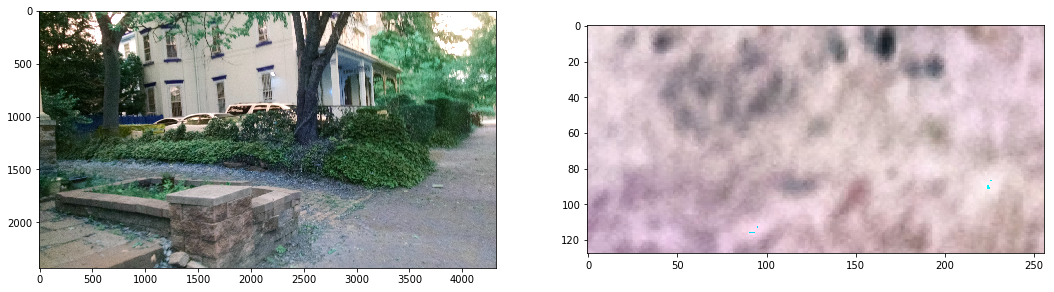

In [16]:
# Test cropping

#### OPTIONAL -- NEEDN'T RUN ####

testIm = readAndCrop(X_train[13],(128,256))
fig = figure(figsize=(18, 10))
fig.add_subplot(1,2,1)
imshow(cv2.imread(X_train[13]))
fig.add_subplot(1,2,2)
imshow(testIm)
plt.show()

Seems about right. On to the network.

In [2]:
### Version 2.0. Transfer learning from ResNet50 trained on imagenet ###

# Flatten, add a relu activated dense layer with 256 units
# Then a softmax layer with output corresponding to 10 classes
# Reading images in batches, cropping centraly (128, 128)
# Compiling with adam and cross entropy

inputShape = (256, 256, 3)
base = ResNet50(weights = 'imagenet',
                  include_top = False, # not loading the dense layers
                  input_shape = inputShape)
base.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 32, 32, 512)  0           add_7[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 16, 16, 256)  131328      activation_22[0][0]              
__________________________________________________________________________________________________
bn4a_branch2a (BatchNormalizati (None, 16, 16, 256)  1024        res4a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 16, 16, 256)  0           bn4a_branch2a[0][0]              
__________________________________________________________________________________________________
res4a_bran

__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 8, 8, 512)    2359808     activation_44[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 8, 8, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 8, 8, 512)    0           bn5b_branch2b[0][0]              
__________________________________________________________________________________________________
res5b_branch2c (Conv2D)         (None, 8, 8, 2048)   1050624     activation_45[0][0]              
__________________________________________________________________________________________________
bn5b_branch2c (BatchNormalizati (None, 8, 8, 2048)   8192        res5b_branch2c[0][0]             
__________

Note: Had trouble automatically downloading the weights. Downloaded manually from github and copied to ~.keras/models

In [9]:
# Build on top of the pretrained ResNet50

inputToRes = layers.Input(shape=inputShape,name = 'image_input')
outputOfRes = base(inputToRes)
x = layers.Flatten(name = 'Flatten')(outputOfRes) 
x = layers.Dense(256, activation ='relu', name = 'Fully_Connected')(x) # Add a fully connected layer
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation = 'softmax')(x) # Add a softmax layer to output 10 classes
mRes = Model(inputs = inputToRes, outputs = x)


Note: Kept getting a scope error after attempting to add ResNet50 as a layer to my new model. The internet suggested I downgrade Keras further to 2.1.2. 
This fixed the issue.

In [7]:
mRes.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
Flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
Fully_Connected (Dense)      (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 24,114,826
Trainable params: 527,114
Non-trainable params: 23,587,712
__________________________________________________________

Note: Even though the output of ResNet50 is effectively 1D, the mRes graph cannot be built without flattening this layer first.

In [11]:
mRes.compile(optimizer = 'adam',
         loss = 'categorical_crossentropy',
         metrics = ['accuracy'])

In [11]:
def trainForSomeEpochs2(model, X_train, epochs):
    # Same as the first one but with crop instead of resize
    
    # Split the training set into folds (batches)



    # Train a number of epochs reading and training on one batch only at a time

    #########################################
    ######## !!!!!!!! TRAINING !!!!! ########
    #########################################

    for epoch in range(0,epochs):
        
        batchNo = 0
        ind = [x for x in range(0,len(X_train))]
        kf = KFold(n_splits=275,random_state=15)
        folds = kf.split(ind) # it's a generator!
        
        for _, testIndices in tqdm(folds):
            testBatch = [readAndCrop(X_train[i],(256,256)) for i in testIndices]
            testBatch = np.array(testBatch)
            testLabels = one_hot_train[testIndices]
            model.train_on_batch(testBatch, testLabels)
            batchNo+=1 
            
        print(epoch, "Done with one epoch!")
    return

In [27]:
###### !!!! TRAINING !!! #####

tic = time.time()
trainForSomeEpochs2(mRes, X_train, 1)
toc = time.time()
print("Finished this preliminary training in {} minutes.".format((toc-tic)/60))

0it [00:00, ?it/s]

1 Done with one batch! Can I haz cookie?


1it [00:29, 29.26s/it]

2 Done with one batch! Can I haz cookie?


2it [00:40, 20.40s/it]

3 Done with one batch! Can I haz cookie?


3it [00:48, 16.19s/it]

4 Done with one batch! Can I haz cookie?


4it [00:58, 14.72s/it]

5 Done with one batch! Can I haz cookie?


5it [01:09, 13.85s/it]

6 Done with one batch! Can I haz cookie?


6it [01:16, 12.71s/it]

7 Done with one batch! Can I haz cookie?


7it [01:24, 12.14s/it]

8 Done with one batch! Can I haz cookie?


8it [01:32, 11.53s/it]

9 Done with one batch! Can I haz cookie?


9it [01:41, 11.27s/it]

10 Done with one batch! Can I haz cookie?


10it [01:48, 10.87s/it]

11 Done with one batch! Can I haz cookie?


11it [01:57, 10.70s/it]

12 Done with one batch! Can I haz cookie?


12it [02:04, 10.40s/it]

13 Done with one batch! Can I haz cookie?


13it [02:11, 10.15s/it]

14 Done with one batch! Can I haz cookie?


14it [02:18,  9.92s/it]

15 Done with one batch! Can I haz cookie?


15it [02:27,  9.80s/it]

16 Done with one batch! Can I haz cookie?


16it [02:35,  9.70s/it]

17 Done with one batch! Can I haz cookie?


17it [02:42,  9.58s/it]

18 Done with one batch! Can I haz cookie?


18it [02:51,  9.52s/it]

19 Done with one batch! Can I haz cookie?


19it [02:58,  9.42s/it]

20 Done with one batch! Can I haz cookie?


20it [03:08,  9.44s/it]

21 Done with one batch! Can I haz cookie?


21it [03:16,  9.36s/it]

22 Done with one batch! Can I haz cookie?


22it [03:24,  9.28s/it]

23 Done with one batch! Can I haz cookie?


23it [03:33,  9.27s/it]

24 Done with one batch! Can I haz cookie?


24it [03:40,  9.18s/it]

25 Done with one batch! Can I haz cookie?


25it [03:48,  9.14s/it]

26 Done with one batch! Can I haz cookie?


26it [03:56,  9.11s/it]

27 Done with one batch! Can I haz cookie?


27it [04:04,  9.05s/it]

28 Done with one batch! Can I haz cookie?


28it [04:12,  9.02s/it]

29 Done with one batch! Can I haz cookie?


29it [04:20,  8.99s/it]

30 Done with one batch! Can I haz cookie?


30it [04:29,  8.98s/it]

31 Done with one batch! Can I haz cookie?


31it [04:37,  8.95s/it]

32 Done with one batch! Can I haz cookie?


32it [04:46,  8.94s/it]

33 Done with one batch! Can I haz cookie?


33it [04:54,  8.91s/it]

34 Done with one batch! Can I haz cookie?


34it [05:02,  8.90s/it]

35 Done with one batch! Can I haz cookie?


35it [05:09,  8.85s/it]

36 Done with one batch! Can I haz cookie?


36it [05:17,  8.81s/it]

37 Done with one batch! Can I haz cookie?


37it [05:25,  8.79s/it]

38 Done with one batch! Can I haz cookie?


38it [05:33,  8.77s/it]

39 Done with one batch! Can I haz cookie?


39it [05:41,  8.76s/it]

40 Done with one batch! Can I haz cookie?


40it [05:50,  8.76s/it]

41 Done with one batch! Can I haz cookie?


41it [05:58,  8.74s/it]

42 Done with one batch! Can I haz cookie?


42it [06:06,  8.72s/it]

43 Done with one batch! Can I haz cookie?


43it [06:14,  8.71s/it]

44 Done with one batch! Can I haz cookie?


44it [06:22,  8.69s/it]

45 Done with one batch! Can I haz cookie?


45it [06:30,  8.69s/it]

46 Done with one batch! Can I haz cookie?


46it [06:38,  8.67s/it]

47 Done with one batch! Can I haz cookie?


47it [06:46,  8.66s/it]

48 Done with one batch! Can I haz cookie?


48it [06:54,  8.64s/it]

49 Done with one batch! Can I haz cookie?


49it [07:03,  8.63s/it]

50 Done with one batch! Can I haz cookie?


50it [07:11,  8.63s/it]

51 Done with one batch! Can I haz cookie?


51it [07:18,  8.61s/it]

52 Done with one batch! Can I haz cookie?


52it [07:27,  8.60s/it]

53 Done with one batch! Can I haz cookie?


53it [07:35,  8.59s/it]

54 Done with one batch! Can I haz cookie?


54it [07:42,  8.57s/it]

55 Done with one batch! Can I haz cookie?


55it [07:51,  8.58s/it]

56 Done with one batch! Can I haz cookie?


56it [08:00,  8.58s/it]

57 Done with one batch! Can I haz cookie?


57it [08:08,  8.56s/it]

58 Done with one batch! Can I haz cookie?


58it [08:15,  8.54s/it]

59 Done with one batch! Can I haz cookie?


59it [08:23,  8.54s/it]

60 Done with one batch! Can I haz cookie?


60it [08:32,  8.55s/it]

61 Done with one batch! Can I haz cookie?


61it [08:41,  8.55s/it]

62 Done with one batch! Can I haz cookie?


62it [08:50,  8.55s/it]

63 Done with one batch! Can I haz cookie?


63it [08:59,  8.56s/it]

64 Done with one batch! Can I haz cookie?


64it [09:07,  8.55s/it]

65 Done with one batch! Can I haz cookie?


65it [09:20,  8.62s/it]

66 Done with one batch! Can I haz cookie?


66it [09:28,  8.62s/it]

67 Done with one batch! Can I haz cookie?


67it [09:37,  8.63s/it]

68 Done with one batch! Can I haz cookie?


68it [09:45,  8.62s/it]

69 Done with one batch! Can I haz cookie?


69it [09:55,  8.63s/it]

70 Done with one batch! Can I haz cookie?


70it [10:03,  8.62s/it]

71 Done with one batch! Can I haz cookie?


71it [10:10,  8.60s/it]

72 Done with one batch! Can I haz cookie?


72it [10:18,  8.59s/it]

73 Done with one batch! Can I haz cookie?


73it [10:27,  8.60s/it]

74 Done with one batch! Can I haz cookie?


74it [10:35,  8.58s/it]

75 Done with one batch! Can I haz cookie?


75it [10:43,  8.59s/it]

76 Done with one batch! Can I haz cookie?


76it [10:51,  8.57s/it]

77 Done with one batch! Can I haz cookie?


77it [11:00,  8.58s/it]

78 Done with one batch! Can I haz cookie?


78it [11:08,  8.57s/it]

79 Done with one batch! Can I haz cookie?


79it [11:18,  8.59s/it]

80 Done with one batch! Can I haz cookie?


80it [11:25,  8.57s/it]

81 Done with one batch! Can I haz cookie?


81it [11:33,  8.56s/it]

82 Done with one batch! Can I haz cookie?


82it [11:40,  8.55s/it]

83 Done with one batch! Can I haz cookie?


83it [11:48,  8.54s/it]

84 Done with one batch! Can I haz cookie?


84it [11:55,  8.52s/it]

85 Done with one batch! Can I haz cookie?


85it [12:04,  8.52s/it]

86 Done with one batch! Can I haz cookie?


86it [12:13,  8.52s/it]

87 Done with one batch! Can I haz cookie?


87it [12:21,  8.52s/it]

88 Done with one batch! Can I haz cookie?


88it [12:29,  8.51s/it]

89 Done with one batch! Can I haz cookie?


89it [12:37,  8.51s/it]

90 Done with one batch! Can I haz cookie?


90it [12:45,  8.50s/it]

91 Done with one batch! Can I haz cookie?


91it [12:52,  8.49s/it]

92 Done with one batch! Can I haz cookie?


92it [12:59,  8.48s/it]

93 Done with one batch! Can I haz cookie?


93it [13:10,  8.50s/it]

94 Done with one batch! Can I haz cookie?


94it [13:18,  8.49s/it]

95 Done with one batch! Can I haz cookie?


95it [13:26,  8.49s/it]

96 Done with one batch! Can I haz cookie?


96it [13:34,  8.48s/it]

97 Done with one batch! Can I haz cookie?


97it [13:42,  8.48s/it]

98 Done with one batch! Can I haz cookie?


98it [13:50,  8.47s/it]

99 Done with one batch! Can I haz cookie?


99it [13:58,  8.47s/it]

100 Done with one batch! Can I haz cookie?


100it [14:06,  8.47s/it]

101 Done with one batch! Can I haz cookie?


101it [14:15,  8.47s/it]

102 Done with one batch! Can I haz cookie?


102it [14:24,  8.47s/it]

103 Done with one batch! Can I haz cookie?


103it [14:32,  8.47s/it]

104 Done with one batch! Can I haz cookie?


104it [14:39,  8.46s/it]

105 Done with one batch! Can I haz cookie?


105it [14:48,  8.46s/it]

106 Done with one batch! Can I haz cookie?


106it [14:56,  8.46s/it]

107 Done with one batch! Can I haz cookie?


107it [15:05,  8.46s/it]

108 Done with one batch! Can I haz cookie?


108it [15:12,  8.45s/it]

109 Done with one batch! Can I haz cookie?


109it [15:21,  8.45s/it]

110 Done with one batch! Can I haz cookie?


110it [15:29,  8.45s/it]

111 Done with one batch! Can I haz cookie?


111it [15:37,  8.44s/it]

112 Done with one batch! Can I haz cookie?


112it [15:45,  8.44s/it]

113 Done with one batch! Can I haz cookie?


113it [15:53,  8.43s/it]

114 Done with one batch! Can I haz cookie?


114it [16:00,  8.43s/it]

115 Done with one batch! Can I haz cookie?


115it [16:08,  8.42s/it]

116 Done with one batch! Can I haz cookie?


116it [16:16,  8.42s/it]

117 Done with one batch! Can I haz cookie?


117it [16:25,  8.42s/it]

118 Done with one batch! Can I haz cookie?


118it [16:33,  8.42s/it]

119 Done with one batch! Can I haz cookie?


119it [16:41,  8.41s/it]

120 Done with one batch! Can I haz cookie?


120it [16:49,  8.42s/it]

121 Done with one batch! Can I haz cookie?


121it [16:58,  8.42s/it]

122 Done with one batch! Can I haz cookie?


122it [17:06,  8.42s/it]

123 Done with one batch! Can I haz cookie?


123it [17:16,  8.42s/it]

124 Done with one batch! Can I haz cookie?


124it [17:23,  8.42s/it]

125 Done with one batch! Can I haz cookie?


125it [17:32,  8.42s/it]

126 Done with one batch! Can I haz cookie?


126it [17:40,  8.42s/it]

127 Done with one batch! Can I haz cookie?


127it [17:49,  8.42s/it]

128 Done with one batch! Can I haz cookie?


128it [17:56,  8.41s/it]

129 Done with one batch! Can I haz cookie?


129it [18:04,  8.41s/it]

130 Done with one batch! Can I haz cookie?


130it [18:12,  8.40s/it]

131 Done with one batch! Can I haz cookie?


131it [18:21,  8.41s/it]

132 Done with one batch! Can I haz cookie?


132it [18:29,  8.41s/it]

133 Done with one batch! Can I haz cookie?


133it [18:37,  8.40s/it]

134 Done with one batch! Can I haz cookie?


134it [18:45,  8.40s/it]

135 Done with one batch! Can I haz cookie?


135it [18:54,  8.40s/it]

136 Done with one batch! Can I haz cookie?


136it [19:02,  8.40s/it]

137 Done with one batch! Can I haz cookie?


137it [19:11,  8.40s/it]

138 Done with one batch! Can I haz cookie?


138it [19:19,  8.40s/it]

139 Done with one batch! Can I haz cookie?


139it [19:27,  8.40s/it]

140 Done with one batch! Can I haz cookie?


140it [19:36,  8.40s/it]

141 Done with one batch! Can I haz cookie?


141it [19:43,  8.40s/it]

142 Done with one batch! Can I haz cookie?


142it [19:52,  8.40s/it]

143 Done with one batch! Can I haz cookie?


143it [20:00,  8.39s/it]

144 Done with one batch! Can I haz cookie?


144it [20:08,  8.39s/it]

145 Done with one batch! Can I haz cookie?


145it [20:15,  8.38s/it]

146 Done with one batch! Can I haz cookie?


146it [20:23,  8.38s/it]

147 Done with one batch! Can I haz cookie?


147it [20:31,  8.38s/it]

148 Done with one batch! Can I haz cookie?


148it [20:39,  8.37s/it]

149 Done with one batch! Can I haz cookie?


149it [20:47,  8.37s/it]

150 Done with one batch! Can I haz cookie?


150it [20:55,  8.37s/it]

151 Done with one batch! Can I haz cookie?


151it [21:03,  8.37s/it]

152 Done with one batch! Can I haz cookie?


152it [21:11,  8.37s/it]

153 Done with one batch! Can I haz cookie?


153it [21:21,  8.37s/it]

154 Done with one batch! Can I haz cookie?


154it [21:29,  8.37s/it]

155 Done with one batch! Can I haz cookie?


155it [21:36,  8.37s/it]

156 Done with one batch! Can I haz cookie?


156it [21:45,  8.37s/it]

157 Done with one batch! Can I haz cookie?


157it [21:52,  8.36s/it]

158 Done with one batch! Can I haz cookie?


158it [22:01,  8.36s/it]

159 Done with one batch! Can I haz cookie?


159it [22:10,  8.37s/it]

160 Done with one batch! Can I haz cookie?


160it [22:18,  8.36s/it]

161 Done with one batch! Can I haz cookie?


161it [22:26,  8.36s/it]

162 Done with one batch! Can I haz cookie?


162it [22:34,  8.36s/it]

163 Done with one batch! Can I haz cookie?


163it [22:42,  8.36s/it]

164 Done with one batch! Can I haz cookie?


164it [22:50,  8.36s/it]

165 Done with one batch! Can I haz cookie?


165it [22:58,  8.35s/it]

166 Done with one batch! Can I haz cookie?


166it [23:07,  8.36s/it]

167 Done with one batch! Can I haz cookie?


167it [23:15,  8.35s/it]

168 Done with one batch! Can I haz cookie?


168it [23:23,  8.35s/it]

169 Done with one batch! Can I haz cookie?


169it [23:30,  8.35s/it]

170 Done with one batch! Can I haz cookie?


170it [23:38,  8.34s/it]

171 Done with one batch! Can I haz cookie?


171it [23:46,  8.34s/it]

172 Done with one batch! Can I haz cookie?


172it [23:55,  8.34s/it]

173 Done with one batch! Can I haz cookie?


173it [24:03,  8.34s/it]

174 Done with one batch! Can I haz cookie?


174it [24:11,  8.34s/it]

175 Done with one batch! Can I haz cookie?


175it [24:19,  8.34s/it]

176 Done with one batch! Can I haz cookie?


176it [24:28,  8.34s/it]

177 Done with one batch! Can I haz cookie?


177it [24:36,  8.34s/it]

178 Done with one batch! Can I haz cookie?


178it [24:44,  8.34s/it]

179 Done with one batch! Can I haz cookie?


179it [24:52,  8.34s/it]

180 Done with one batch! Can I haz cookie?


180it [25:04,  8.36s/it]

181 Done with one batch! Can I haz cookie?


181it [25:14,  8.37s/it]

182 Done with one batch! Can I haz cookie?


182it [25:22,  8.36s/it]

183 Done with one batch! Can I haz cookie?


183it [25:31,  8.37s/it]

184 Done with one batch! Can I haz cookie?


184it [25:39,  8.36s/it]

185 Done with one batch! Can I haz cookie?


185it [25:46,  8.36s/it]

186 Done with one batch! Can I haz cookie?


186it [25:55,  8.36s/it]

187 Done with one batch! Can I haz cookie?


187it [26:03,  8.36s/it]

188 Done with one batch! Can I haz cookie?


188it [26:10,  8.36s/it]

189 Done with one batch! Can I haz cookie?


189it [26:19,  8.36s/it]

190 Done with one batch! Can I haz cookie?


190it [26:27,  8.36s/it]

191 Done with one batch! Can I haz cookie?


191it [26:36,  8.36s/it]

192 Done with one batch! Can I haz cookie?


192it [26:44,  8.36s/it]

193 Done with one batch! Can I haz cookie?


193it [26:52,  8.35s/it]

194 Done with one batch! Can I haz cookie?


194it [27:00,  8.35s/it]

195 Done with one batch! Can I haz cookie?


195it [27:10,  8.36s/it]

196 Done with one batch! Can I haz cookie?


196it [27:18,  8.36s/it]

197 Done with one batch! Can I haz cookie?


197it [27:26,  8.36s/it]

198 Done with one batch! Can I haz cookie?


198it [27:35,  8.36s/it]

199 Done with one batch! Can I haz cookie?


199it [27:42,  8.36s/it]

200 Done with one batch! Can I haz cookie?


200it [27:50,  8.35s/it]

201 Done with one batch! Can I haz cookie?


201it [27:57,  8.35s/it]

202 Done with one batch! Can I haz cookie?


202it [28:05,  8.35s/it]

203 Done with one batch! Can I haz cookie?


203it [28:14,  8.34s/it]

204 Done with one batch! Can I haz cookie?


204it [28:22,  8.34s/it]

205 Done with one batch! Can I haz cookie?


205it [28:30,  8.34s/it]

206 Done with one batch! Can I haz cookie?


206it [28:38,  8.34s/it]

207 Done with one batch! Can I haz cookie?


207it [28:47,  8.35s/it]

208 Done with one batch! Can I haz cookie?


208it [28:55,  8.34s/it]

209 Done with one batch! Can I haz cookie?


209it [29:03,  8.34s/it]

210 Done with one batch! Can I haz cookie?


210it [29:11,  8.34s/it]

211 Done with one batch! Can I haz cookie?


211it [29:19,  8.34s/it]

212 Done with one batch! Can I haz cookie?


212it [29:27,  8.34s/it]

213 Done with one batch! Can I haz cookie?


213it [29:36,  8.34s/it]

214 Done with one batch! Can I haz cookie?


214it [29:44,  8.34s/it]

215 Done with one batch! Can I haz cookie?


215it [29:52,  8.34s/it]

216 Done with one batch! Can I haz cookie?


216it [30:00,  8.34s/it]

217 Done with one batch! Can I haz cookie?


217it [30:08,  8.34s/it]

218 Done with one batch! Can I haz cookie?


218it [30:17,  8.34s/it]

219 Done with one batch! Can I haz cookie?


219it [30:25,  8.34s/it]

220 Done with one batch! Can I haz cookie?


220it [30:35,  8.34s/it]

221 Done with one batch! Can I haz cookie?


221it [30:43,  8.34s/it]

222 Done with one batch! Can I haz cookie?


222it [30:52,  8.34s/it]

223 Done with one batch! Can I haz cookie?


223it [30:59,  8.34s/it]

224 Done with one batch! Can I haz cookie?


224it [31:08,  8.34s/it]

225 Done with one batch! Can I haz cookie?


225it [31:16,  8.34s/it]

226 Done with one batch! Can I haz cookie?


226it [31:23,  8.33s/it]

227 Done with one batch! Can I haz cookie?


227it [31:31,  8.33s/it]

228 Done with one batch! Can I haz cookie?


228it [31:40,  8.33s/it]

229 Done with one batch! Can I haz cookie?


229it [31:48,  8.33s/it]

230 Done with one batch! Can I haz cookie?


230it [31:56,  8.33s/it]

231 Done with one batch! Can I haz cookie?


231it [32:09,  8.35s/it]

232 Done with one batch! Can I haz cookie?


232it [32:21,  8.37s/it]

233 Done with one batch! Can I haz cookie?


233it [32:33,  8.38s/it]

234 Done with one batch! Can I haz cookie?


234it [32:41,  8.38s/it]

235 Done with one batch! Can I haz cookie?


235it [32:53,  8.40s/it]

236 Done with one batch! Can I haz cookie?


236it [33:01,  8.40s/it]

237 Done with one batch! Can I haz cookie?


237it [33:10,  8.40s/it]

238 Done with one batch! Can I haz cookie?


238it [33:19,  8.40s/it]

239 Done with one batch! Can I haz cookie?


239it [33:26,  8.40s/it]

240 Done with one batch! Can I haz cookie?


240it [33:34,  8.39s/it]

241 Done with one batch! Can I haz cookie?


241it [33:42,  8.39s/it]

242 Done with one batch! Can I haz cookie?


242it [33:49,  8.39s/it]

243 Done with one batch! Can I haz cookie?


243it [33:59,  8.39s/it]

244 Done with one batch! Can I haz cookie?


244it [34:08,  8.39s/it]

245 Done with one batch! Can I haz cookie?


245it [34:17,  8.40s/it]

246 Done with one batch! Can I haz cookie?


246it [34:25,  8.40s/it]

247 Done with one batch! Can I haz cookie?


247it [34:33,  8.39s/it]

248 Done with one batch! Can I haz cookie?


248it [34:40,  8.39s/it]

249 Done with one batch! Can I haz cookie?


249it [34:50,  8.39s/it]

250 Done with one batch! Can I haz cookie?


250it [34:58,  8.39s/it]

251 Done with one batch! Can I haz cookie?


251it [35:09,  8.41s/it]

252 Done with one batch! Can I haz cookie?


252it [35:18,  8.41s/it]

253 Done with one batch! Can I haz cookie?


253it [35:26,  8.40s/it]

254 Done with one batch! Can I haz cookie?


254it [35:35,  8.41s/it]

255 Done with one batch! Can I haz cookie?


255it [35:43,  8.41s/it]

256 Done with one batch! Can I haz cookie?


256it [35:51,  8.40s/it]

257 Done with one batch! Can I haz cookie?


257it [35:58,  8.40s/it]

258 Done with one batch! Can I haz cookie?


258it [36:07,  8.40s/it]

259 Done with one batch! Can I haz cookie?


259it [36:15,  8.40s/it]

260 Done with one batch! Can I haz cookie?


260it [36:22,  8.40s/it]

261 Done with one batch! Can I haz cookie?


261it [36:30,  8.39s/it]

262 Done with one batch! Can I haz cookie?


262it [36:38,  8.39s/it]

263 Done with one batch! Can I haz cookie?


263it [36:47,  8.39s/it]

264 Done with one batch! Can I haz cookie?


264it [36:55,  8.39s/it]

265 Done with one batch! Can I haz cookie?


265it [37:03,  8.39s/it]

266 Done with one batch! Can I haz cookie?


266it [37:12,  8.39s/it]

267 Done with one batch! Can I haz cookie?


267it [37:21,  8.40s/it]

268 Done with one batch! Can I haz cookie?


268it [37:29,  8.40s/it]

269 Done with one batch! Can I haz cookie?


269it [37:38,  8.40s/it]

270 Done with one batch! Can I haz cookie?


270it [37:46,  8.39s/it]

271 Done with one batch! Can I haz cookie?


271it [37:56,  8.40s/it]

272 Done with one batch! Can I haz cookie?


272it [38:03,  8.40s/it]

273 Done with one batch! Can I haz cookie?


273it [38:11,  8.39s/it]

274 Done with one batch! Can I haz cookie?


274it [38:18,  8.39s/it]

275 Done with one batch! Can I haz cookie?


275it [38:27,  8.39s/it]


0 Done with one epoch!
Finished this preliminary training in 38.47583402395249 minutes.


In [29]:
saveModel(mRes,'mRes')

Saved model to disk


Fingers crossed this model is not tunnel visioning class 1. 

In [30]:
# Similar as the one above, just crop instead of resize and included model as argument
def getPredictions2(testSetPaths, model):
    scores = []
    noPasses = len(testSetPaths)//50
    for i in range(0,noPasses):
        if i!= noPasses-1:
            testBatch = np.array([readAndCrop(im,(256,256)) for im in tqdm(testSetPaths[i*50:(i+1)*50])])
            print("Loaded batch {} out of {}...testing...".format(i+1,noPasses))
            scoreBatch = model.predict(testBatch)
        else:
            testBatch = np.array([readAndCrop(im,(256,256)) for im in testSetPaths[i*50:]])
            print("Loaded last batch...testing...")
            scoreBatch = model.predict(testBatch)
        scores = np.append(scores,scoreBatch)    
    return scores

In [ ]:
tic = time.time()
scoresRes = getPredictions2(X_test, mRes)

# s is a 1D array. Reshape. 
sRes = scoresRes.reshape((len(scoresRes)//10,10))

# get back the labels
predLabels = [backFromOneHot(sLine) for sLine in sRes]

# get accuracy
a = weightedAccuracy(X_test,predLabels)

toc = time.time()
print("Finished this evaluation in {} min".format((toc-tic)//60))

print("Here are some labels: ")
print(predLabels[0:20])

print("And here is your weighted accuracy: ", a)

100%|██████████████████████████████████████████| 50/50 [06:06<00:00,  7.33s/it]


Loaded batch 1 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [04:22<00:00,  5.25s/it]


Loaded batch 2 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [04:30<00:00,  5.41s/it]


Loaded batch 3 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [07:07<00:00,  8.55s/it]


Loaded batch 4 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [04:17<00:00,  5.15s/it]


Loaded batch 5 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [04:58<00:00,  5.97s/it]


Loaded batch 6 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [05:52<00:00,  7.05s/it]


Loaded batch 7 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [04:39<00:00,  5.59s/it]


Loaded batch 8 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [02:48<00:00,  3.37s/it]


Loaded batch 9 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [06:18<00:00,  7.57s/it]


Loaded batch 10 out of 11...testing...


In [34]:
scoresRes

array([  2.43838411e-04,   5.29410899e-01,   2.31183589e-01, ...,
         2.06400812e-01,   1.65574878e-01,   2.81362943e-02])

After several hours of calculating, jupyter reports "Websocket ping timeout". After refreshing the page, I can however access some variables.

In [36]:
sRes

array([[  2.43838411e-04,   5.29410899e-01,   2.31183589e-01, ...,
          1.61490683e-03,   1.29775023e-02,   3.35341729e-02],
       [  2.36268625e-01,   1.79077372e-01,   4.55505326e-02, ...,
          1.51652485e-01,   5.31675518e-02,   2.12936979e-02],
       [  5.17672896e-01,   8.71662330e-03,   3.77526251e-03, ...,
          2.58593798e-01,   1.22100266e-03,   4.27158969e-03],
       ..., 
       [  1.34633295e-02,   1.34872735e-01,   2.30095714e-01, ...,
          4.23301458e-02,   3.36081386e-01,   1.25616804e-01],
       [  9.93483420e-03,   5.09791374e-02,   2.69973818e-02, ...,
          5.88148534e-02,   6.41843118e-03,   3.69052738e-02],
       [  2.78039882e-03,   2.04883218e-02,   3.35003808e-02, ...,
          2.06400812e-01,   1.65574878e-01,   2.81362943e-02]])

In [37]:
predLabels

['Motorola-X',
 'Sony-NEX-7',
 'Sony-NEX-7',
 'LG-Nexus-5x',
 'HTC-1-M7',
 'Samsung-Galaxy-S4',
 'Samsung-Galaxy-S4',
 'Samsung-Galaxy-Note3',
 'Motorola-X',
 'Motorola-Droid-Maxx',
 'iPhone-4s',
 'iPhone-4s',
 'iPhone-4s',
 'HTC-1-M7',
 'Samsung-Galaxy-Note3',
 'Samsung-Galaxy-Note3',
 'Samsung-Galaxy-S4',
 'Sony-NEX-7',
 'LG-Nexus-5x',
 'Motorola-Droid-Maxx',
 'Sony-NEX-7',
 'Samsung-Galaxy-S4',
 'HTC-1-M7',
 'HTC-1-M7',
 'HTC-1-M7',
 'HTC-1-M7',
 'LG-Nexus-5x',
 'Sony-NEX-7',
 'Sony-NEX-7',
 'Motorola-Droid-Maxx',
 'Motorola-X',
 'Motorola-Droid-Maxx',
 'LG-Nexus-5x',
 'HTC-1-M7',
 'Motorola-X',
 'iPhone-4s',
 'iPhone-4s',
 'Motorola-Droid-Maxx',
 'HTC-1-M7',
 'iPhone-4s',
 'Sony-NEX-7',
 'Sony-NEX-7',
 'Samsung-Galaxy-S4',
 'Samsung-Galaxy-Note3',
 'Samsung-Galaxy-S4',
 'iPhone-4s',
 'LG-Nexus-5x',
 'HTC-1-M7',
 'iPhone-4s',
 'Motorola-Nexus-6',
 'LG-Nexus-5x',
 'iPhone-4s',
 'iPhone-4s',
 'Sony-NEX-7',
 'Motorola-Droid-Maxx',
 'Samsung-Galaxy-Note3',
 'Samsung-Galaxy-Note3',
 'iPh

In [40]:
a = weightedAccuracy(X_test,predLabels)

In [41]:
print(a)

0.514545454545


Okay, looking better. 

So officially, my currently best model has 51,4% accuracy on the validation set. More training should improve this.
More data should also improve it - augment the dataset by taking crops other than the central one; rotating; fliping; download and include data from flickr or other sources.  
To account for modified images, the training data should also be augmented to include images altered in ways denoted in the competition description.

In [42]:
tic = time.time()
trainForSomeEpochs2(mRes, X_train, 2)
toc = time.time()
print("Finished these two epochs in {} minutes.".format((toc-tic)/60))
saveModel(mRes,'mRes2')

0it [00:00, ?it/s]

1 Done with one batch! Can I haz cookie?


1it [00:18, 18.84s/it]

2 Done with one batch! Can I haz cookie?


2it [00:30, 15.28s/it]

3 Done with one batch! Can I haz cookie?


3it [00:38, 12.71s/it]

4 Done with one batch! Can I haz cookie?


4it [00:47, 11.81s/it]

5 Done with one batch! Can I haz cookie?


5it [00:55, 11.04s/it]

6 Done with one batch! Can I haz cookie?


6it [01:02, 10.42s/it]

7 Done with one batch! Can I haz cookie?


7it [01:09,  9.97s/it]

8 Done with one batch! Can I haz cookie?


8it [01:16,  9.57s/it]

9 Done with one batch! Can I haz cookie?


9it [01:24,  9.43s/it]

10 Done with one batch! Can I haz cookie?


10it [01:32,  9.23s/it]

11 Done with one batch! Can I haz cookie?


11it [01:39,  9.04s/it]

12 Done with one batch! Can I haz cookie?


12it [01:47,  8.94s/it]

13 Done with one batch! Can I haz cookie?


13it [01:54,  8.82s/it]

14 Done with one batch! Can I haz cookie?


14it [02:01,  8.71s/it]

15 Done with one batch! Can I haz cookie?


15it [02:09,  8.64s/it]

16 Done with one batch! Can I haz cookie?


16it [02:18,  8.64s/it]

17 Done with one batch! Can I haz cookie?


17it [02:29,  8.77s/it]

18 Done with one batch! Can I haz cookie?


18it [02:36,  8.69s/it]

19 Done with one batch! Can I haz cookie?


19it [02:43,  8.62s/it]

20 Done with one batch! Can I haz cookie?


20it [02:52,  8.62s/it]

21 Done with one batch! Can I haz cookie?


21it [03:00,  8.61s/it]

22 Done with one batch! Can I haz cookie?


22it [03:08,  8.57s/it]

23 Done with one batch! Can I haz cookie?


23it [03:17,  8.60s/it]

24 Done with one batch! Can I haz cookie?


24it [03:24,  8.53s/it]

25 Done with one batch! Can I haz cookie?


25it [03:32,  8.49s/it]

26 Done with one batch! Can I haz cookie?


26it [03:40,  8.47s/it]

27 Done with one batch! Can I haz cookie?


27it [03:47,  8.44s/it]

28 Done with one batch! Can I haz cookie?


28it [03:55,  8.41s/it]

29 Done with one batch! Can I haz cookie?


29it [04:03,  8.40s/it]

30 Done with one batch! Can I haz cookie?


30it [04:12,  8.40s/it]

31 Done with one batch! Can I haz cookie?


31it [04:19,  8.39s/it]

32 Done with one batch! Can I haz cookie?


32it [04:28,  8.39s/it]

33 Done with one batch! Can I haz cookie?


33it [04:36,  8.37s/it]

34 Done with one batch! Can I haz cookie?


34it [04:44,  8.36s/it]

35 Done with one batch! Can I haz cookie?


35it [04:51,  8.33s/it]

36 Done with one batch! Can I haz cookie?


36it [05:00,  8.34s/it]

37 Done with one batch! Can I haz cookie?


37it [05:07,  8.31s/it]

38 Done with one batch! Can I haz cookie?


38it [05:15,  8.31s/it]

39 Done with one batch! Can I haz cookie?


39it [05:24,  8.31s/it]

40 Done with one batch! Can I haz cookie?


40it [05:32,  8.32s/it]

41 Done with one batch! Can I haz cookie?


41it [05:40,  8.32s/it]

42 Done with one batch! Can I haz cookie?


42it [05:48,  8.29s/it]

43 Done with one batch! Can I haz cookie?


43it [05:56,  8.28s/it]

44 Done with one batch! Can I haz cookie?


44it [06:04,  8.28s/it]

45 Done with one batch! Can I haz cookie?


45it [06:12,  8.28s/it]

46 Done with one batch! Can I haz cookie?


46it [06:20,  8.26s/it]

47 Done with one batch! Can I haz cookie?


47it [06:28,  8.26s/it]

48 Done with one batch! Can I haz cookie?


48it [06:36,  8.26s/it]

49 Done with one batch! Can I haz cookie?


49it [06:44,  8.26s/it]

50 Done with one batch! Can I haz cookie?


50it [06:53,  8.26s/it]

51 Done with one batch! Can I haz cookie?


51it [07:01,  8.26s/it]

52 Done with one batch! Can I haz cookie?


52it [07:09,  8.25s/it]

53 Done with one batch! Can I haz cookie?


53it [07:17,  8.25s/it]

54 Done with one batch! Can I haz cookie?


54it [07:25,  8.25s/it]

55 Done with one batch! Can I haz cookie?


55it [07:34,  8.26s/it]

56 Done with one batch! Can I haz cookie?


56it [07:43,  8.27s/it]

57 Done with one batch! Can I haz cookie?


57it [07:50,  8.26s/it]

58 Done with one batch! Can I haz cookie?


58it [07:59,  8.27s/it]

59 Done with one batch! Can I haz cookie?


59it [08:08,  8.27s/it]

60 Done with one batch! Can I haz cookie?


60it [08:17,  8.29s/it]

61 Done with one batch! Can I haz cookie?


61it [08:26,  8.30s/it]

62 Done with one batch! Can I haz cookie?


62it [08:35,  8.31s/it]

63 Done with one batch! Can I haz cookie?


63it [08:43,  8.32s/it]

64 Done with one batch! Can I haz cookie?


64it [08:51,  8.30s/it]

65 Done with one batch! Can I haz cookie?


65it [09:00,  8.32s/it]

66 Done with one batch! Can I haz cookie?


66it [09:08,  8.31s/it]

67 Done with one batch! Can I haz cookie?


67it [09:16,  8.30s/it]

68 Done with one batch! Can I haz cookie?


68it [09:24,  8.30s/it]

69 Done with one batch! Can I haz cookie?


69it [09:33,  8.31s/it]

70 Done with one batch! Can I haz cookie?


70it [09:41,  8.31s/it]

71 Done with one batch! Can I haz cookie?


71it [09:49,  8.30s/it]

72 Done with one batch! Can I haz cookie?


72it [09:57,  8.30s/it]

73 Done with one batch! Can I haz cookie?


73it [10:05,  8.30s/it]

74 Done with one batch! Can I haz cookie?


74it [10:13,  8.29s/it]

75 Done with one batch! Can I haz cookie?


75it [10:22,  8.31s/it]

76 Done with one batch! Can I haz cookie?


76it [10:31,  8.31s/it]

77 Done with one batch! Can I haz cookie?


77it [10:40,  8.32s/it]

78 Done with one batch! Can I haz cookie?


78it [10:49,  8.33s/it]

79 Done with one batch! Can I haz cookie?


79it [10:59,  8.34s/it]

80 Done with one batch! Can I haz cookie?


80it [11:08,  8.35s/it]

81 Done with one batch! Can I haz cookie?


81it [11:18,  8.38s/it]

82 Done with one batch! Can I haz cookie?


82it [11:25,  8.37s/it]

83 Done with one batch! Can I haz cookie?


83it [11:34,  8.36s/it]

84 Done with one batch! Can I haz cookie?


84it [11:41,  8.36s/it]

85 Done with one batch! Can I haz cookie?


85it [11:51,  8.37s/it]

86 Done with one batch! Can I haz cookie?


86it [12:00,  8.38s/it]

87 Done with one batch! Can I haz cookie?


87it [12:08,  8.38s/it]

88 Done with one batch! Can I haz cookie?


88it [12:16,  8.37s/it]

89 Done with one batch! Can I haz cookie?


89it [12:25,  8.38s/it]

90 Done with one batch! Can I haz cookie?


90it [12:33,  8.37s/it]

91 Done with one batch! Can I haz cookie?


91it [12:41,  8.37s/it]

92 Done with one batch! Can I haz cookie?


92it [12:48,  8.35s/it]

93 Done with one batch! Can I haz cookie?


93it [12:59,  8.38s/it]

94 Done with one batch! Can I haz cookie?


94it [13:07,  8.38s/it]

95 Done with one batch! Can I haz cookie?


95it [13:15,  8.37s/it]

96 Done with one batch! Can I haz cookie?


96it [13:23,  8.37s/it]

97 Done with one batch! Can I haz cookie?


97it [13:31,  8.37s/it]

98 Done with one batch! Can I haz cookie?


98it [13:40,  8.37s/it]

99 Done with one batch! Can I haz cookie?


99it [13:48,  8.37s/it]

100 Done with one batch! Can I haz cookie?


100it [13:56,  8.37s/it]

101 Done with one batch! Can I haz cookie?


101it [14:04,  8.36s/it]

102 Done with one batch! Can I haz cookie?


102it [14:14,  8.38s/it]

103 Done with one batch! Can I haz cookie?


103it [14:22,  8.38s/it]

104 Done with one batch! Can I haz cookie?


104it [14:30,  8.37s/it]

105 Done with one batch! Can I haz cookie?


105it [14:39,  8.37s/it]

106 Done with one batch! Can I haz cookie?


106it [14:47,  8.37s/it]

107 Done with one batch! Can I haz cookie?


107it [14:55,  8.37s/it]

108 Done with one batch! Can I haz cookie?


108it [15:03,  8.37s/it]

109 Done with one batch! Can I haz cookie?


109it [15:11,  8.37s/it]

110 Done with one batch! Can I haz cookie?


110it [15:20,  8.37s/it]

111 Done with one batch! Can I haz cookie?


111it [15:28,  8.36s/it]

112 Done with one batch! Can I haz cookie?


112it [15:36,  8.36s/it]

113 Done with one batch! Can I haz cookie?


113it [15:44,  8.36s/it]

114 Done with one batch! Can I haz cookie?


114it [15:51,  8.35s/it]

115 Done with one batch! Can I haz cookie?


115it [16:00,  8.35s/it]

116 Done with one batch! Can I haz cookie?


116it [16:08,  8.35s/it]

117 Done with one batch! Can I haz cookie?


117it [16:18,  8.36s/it]

118 Done with one batch! Can I haz cookie?


118it [16:26,  8.36s/it]

119 Done with one batch! Can I haz cookie?


119it [16:34,  8.36s/it]

120 Done with one batch! Can I haz cookie?


120it [16:43,  8.36s/it]

121 Done with one batch! Can I haz cookie?


121it [16:52,  8.37s/it]

122 Done with one batch! Can I haz cookie?


122it [17:01,  8.37s/it]

123 Done with one batch! Can I haz cookie?


123it [17:09,  8.37s/it]

124 Done with one batch! Can I haz cookie?


124it [17:17,  8.37s/it]

125 Done with one batch! Can I haz cookie?


125it [17:25,  8.36s/it]

126 Done with one batch! Can I haz cookie?


126it [17:34,  8.37s/it]

127 Done with one batch! Can I haz cookie?


127it [17:42,  8.37s/it]

128 Done with one batch! Can I haz cookie?


128it [17:50,  8.36s/it]

129 Done with one batch! Can I haz cookie?


129it [17:58,  8.36s/it]

130 Done with one batch! Can I haz cookie?


130it [18:06,  8.36s/it]

131 Done with one batch! Can I haz cookie?


131it [18:15,  8.36s/it]

132 Done with one batch! Can I haz cookie?


132it [18:24,  8.37s/it]

133 Done with one batch! Can I haz cookie?


133it [18:32,  8.36s/it]

134 Done with one batch! Can I haz cookie?


134it [18:40,  8.36s/it]

135 Done with one batch! Can I haz cookie?


135it [18:48,  8.36s/it]

136 Done with one batch! Can I haz cookie?


136it [18:57,  8.36s/it]

137 Done with one batch! Can I haz cookie?


137it [19:06,  8.37s/it]

138 Done with one batch! Can I haz cookie?


138it [19:15,  8.37s/it]

139 Done with one batch! Can I haz cookie?


139it [19:23,  8.37s/it]

140 Done with one batch! Can I haz cookie?


140it [19:32,  8.38s/it]

141 Done with one batch! Can I haz cookie?


141it [19:40,  8.37s/it]

142 Done with one batch! Can I haz cookie?


142it [19:48,  8.37s/it]

143 Done with one batch! Can I haz cookie?


143it [19:57,  8.37s/it]

144 Done with one batch! Can I haz cookie?


144it [20:05,  8.37s/it]

145 Done with one batch! Can I haz cookie?


145it [20:13,  8.37s/it]

146 Done with one batch! Can I haz cookie?


146it [20:21,  8.37s/it]

147 Done with one batch! Can I haz cookie?


147it [20:29,  8.36s/it]

148 Done with one batch! Can I haz cookie?


148it [20:37,  8.36s/it]

149 Done with one batch! Can I haz cookie?


149it [20:45,  8.36s/it]

150 Done with one batch! Can I haz cookie?


150it [20:53,  8.36s/it]

151 Done with one batch! Can I haz cookie?


151it [21:02,  8.36s/it]

152 Done with one batch! Can I haz cookie?


152it [21:11,  8.36s/it]

153 Done with one batch! Can I haz cookie?


153it [21:20,  8.37s/it]

154 Done with one batch! Can I haz cookie?


154it [21:28,  8.37s/it]

155 Done with one batch! Can I haz cookie?


155it [21:36,  8.37s/it]

156 Done with one batch! Can I haz cookie?


156it [21:45,  8.37s/it]

157 Done with one batch! Can I haz cookie?


157it [21:53,  8.36s/it]

158 Done with one batch! Can I haz cookie?


158it [22:01,  8.36s/it]

159 Done with one batch! Can I haz cookie?


159it [22:09,  8.36s/it]

160 Done with one batch! Can I haz cookie?


160it [22:18,  8.36s/it]

161 Done with one batch! Can I haz cookie?


161it [22:26,  8.37s/it]

162 Done with one batch! Can I haz cookie?


162it [22:34,  8.36s/it]

163 Done with one batch! Can I haz cookie?


163it [22:43,  8.36s/it]

164 Done with one batch! Can I haz cookie?


164it [22:52,  8.37s/it]

165 Done with one batch! Can I haz cookie?


165it [23:00,  8.37s/it]

166 Done with one batch! Can I haz cookie?


166it [23:09,  8.37s/it]

167 Done with one batch! Can I haz cookie?


167it [23:17,  8.37s/it]

168 Done with one batch! Can I haz cookie?


168it [23:26,  8.37s/it]

169 Done with one batch! Can I haz cookie?


169it [23:34,  8.37s/it]

170 Done with one batch! Can I haz cookie?


170it [23:41,  8.36s/it]

171 Done with one batch! Can I haz cookie?


171it [23:50,  8.37s/it]

172 Done with one batch! Can I haz cookie?


172it [23:59,  8.37s/it]

173 Done with one batch! Can I haz cookie?


173it [24:07,  8.37s/it]

174 Done with one batch! Can I haz cookie?


174it [24:15,  8.37s/it]

175 Done with one batch! Can I haz cookie?


175it [24:24,  8.37s/it]

176 Done with one batch! Can I haz cookie?


176it [24:32,  8.37s/it]

177 Done with one batch! Can I haz cookie?


177it [24:41,  8.37s/it]

178 Done with one batch! Can I haz cookie?


178it [24:49,  8.37s/it]

179 Done with one batch! Can I haz cookie?


179it [24:57,  8.37s/it]

180 Done with one batch! Can I haz cookie?


180it [25:06,  8.37s/it]

181 Done with one batch! Can I haz cookie?


181it [25:14,  8.37s/it]

182 Done with one batch! Can I haz cookie?


182it [25:22,  8.36s/it]

183 Done with one batch! Can I haz cookie?


183it [25:30,  8.36s/it]

184 Done with one batch! Can I haz cookie?


184it [25:38,  8.36s/it]

185 Done with one batch! Can I haz cookie?


185it [25:46,  8.36s/it]

186 Done with one batch! Can I haz cookie?


186it [25:55,  8.36s/it]

187 Done with one batch! Can I haz cookie?


187it [26:03,  8.36s/it]

188 Done with one batch! Can I haz cookie?


188it [26:11,  8.36s/it]

189 Done with one batch! Can I haz cookie?


189it [26:20,  8.36s/it]

190 Done with one batch! Can I haz cookie?


190it [26:28,  8.36s/it]

191 Done with one batch! Can I haz cookie?


191it [26:37,  8.36s/it]

192 Done with one batch! Can I haz cookie?


192it [26:45,  8.36s/it]

193 Done with one batch! Can I haz cookie?


193it [26:53,  8.36s/it]

194 Done with one batch! Can I haz cookie?


194it [27:02,  8.36s/it]

195 Done with one batch! Can I haz cookie?


195it [27:18,  8.40s/it]

196 Done with one batch! Can I haz cookie?


196it [27:35,  8.45s/it]

197 Done with one batch! Can I haz cookie?


197it [27:48,  8.47s/it]

198 Done with one batch! Can I haz cookie?


198it [27:57,  8.47s/it]

199 Done with one batch! Can I haz cookie?


199it [28:05,  8.47s/it]

200 Done with one batch! Can I haz cookie?


200it [28:13,  8.47s/it]

201 Done with one batch! Can I haz cookie?


201it [28:23,  8.48s/it]

202 Done with one batch! Can I haz cookie?


202it [28:32,  8.48s/it]

203 Done with one batch! Can I haz cookie?


203it [28:41,  8.48s/it]

204 Done with one batch! Can I haz cookie?


204it [28:49,  8.48s/it]

205 Done with one batch! Can I haz cookie?


205it [28:58,  8.48s/it]

206 Done with one batch! Can I haz cookie?


206it [29:07,  8.48s/it]

207 Done with one batch! Can I haz cookie?


207it [29:17,  8.49s/it]

208 Done with one batch! Can I haz cookie?


208it [29:26,  8.49s/it]

209 Done with one batch! Can I haz cookie?


209it [29:35,  8.49s/it]

210 Done with one batch! Can I haz cookie?


210it [29:43,  8.49s/it]

211 Done with one batch! Can I haz cookie?


211it [29:51,  8.49s/it]

212 Done with one batch! Can I haz cookie?


212it [30:00,  8.49s/it]

213 Done with one batch! Can I haz cookie?


213it [30:09,  8.49s/it]

214 Done with one batch! Can I haz cookie?


214it [30:17,  8.49s/it]

215 Done with one batch! Can I haz cookie?


215it [30:26,  8.49s/it]

216 Done with one batch! Can I haz cookie?


216it [30:34,  8.49s/it]

217 Done with one batch! Can I haz cookie?


217it [30:43,  8.49s/it]

218 Done with one batch! Can I haz cookie?


218it [30:53,  8.50s/it]

219 Done with one batch! Can I haz cookie?


219it [31:02,  8.50s/it]

220 Done with one batch! Can I haz cookie?


220it [31:12,  8.51s/it]

221 Done with one batch! Can I haz cookie?


221it [31:20,  8.51s/it]

222 Done with one batch! Can I haz cookie?


222it [31:30,  8.51s/it]

223 Done with one batch! Can I haz cookie?


223it [31:37,  8.51s/it]

224 Done with one batch! Can I haz cookie?


224it [31:47,  8.51s/it]

225 Done with one batch! Can I haz cookie?


225it [31:55,  8.51s/it]

226 Done with one batch! Can I haz cookie?


226it [32:03,  8.51s/it]

227 Done with one batch! Can I haz cookie?


227it [32:12,  8.51s/it]

228 Done with one batch! Can I haz cookie?


228it [32:21,  8.51s/it]

229 Done with one batch! Can I haz cookie?


229it [32:32,  8.52s/it]

230 Done with one batch! Can I haz cookie?


230it [32:44,  8.54s/it]

231 Done with one batch! Can I haz cookie?


231it [32:53,  8.55s/it]

232 Done with one batch! Can I haz cookie?


232it [33:02,  8.55s/it]

233 Done with one batch! Can I haz cookie?


233it [33:11,  8.55s/it]

234 Done with one batch! Can I haz cookie?


234it [33:20,  8.55s/it]

235 Done with one batch! Can I haz cookie?


235it [33:27,  8.54s/it]

236 Done with one batch! Can I haz cookie?


236it [33:36,  8.54s/it]

237 Done with one batch! Can I haz cookie?


237it [33:45,  8.54s/it]

238 Done with one batch! Can I haz cookie?


238it [33:54,  8.55s/it]

239 Done with one batch! Can I haz cookie?


239it [34:02,  8.54s/it]

240 Done with one batch! Can I haz cookie?


240it [34:10,  8.54s/it]

241 Done with one batch! Can I haz cookie?


241it [34:17,  8.54s/it]

242 Done with one batch! Can I haz cookie?


242it [34:26,  8.54s/it]

243 Done with one batch! Can I haz cookie?


243it [34:35,  8.54s/it]

244 Done with one batch! Can I haz cookie?


244it [34:44,  8.54s/it]

245 Done with one batch! Can I haz cookie?


245it [34:59,  8.57s/it]

246 Done with one batch! Can I haz cookie?


246it [35:09,  8.58s/it]

247 Done with one batch! Can I haz cookie?


247it [35:17,  8.57s/it]

248 Done with one batch! Can I haz cookie?


248it [35:26,  8.57s/it]

249 Done with one batch! Can I haz cookie?


249it [35:34,  8.57s/it]

250 Done with one batch! Can I haz cookie?


250it [35:43,  8.57s/it]

251 Done with one batch! Can I haz cookie?


251it [35:51,  8.57s/it]

252 Done with one batch! Can I haz cookie?


252it [36:00,  8.57s/it]

253 Done with one batch! Can I haz cookie?


253it [36:09,  8.57s/it]

254 Done with one batch! Can I haz cookie?


254it [36:18,  8.58s/it]

255 Done with one batch! Can I haz cookie?


255it [36:26,  8.58s/it]

256 Done with one batch! Can I haz cookie?


256it [36:34,  8.57s/it]

257 Done with one batch! Can I haz cookie?


257it [36:42,  8.57s/it]

258 Done with one batch! Can I haz cookie?


258it [36:51,  8.57s/it]

259 Done with one batch! Can I haz cookie?


259it [37:00,  8.57s/it]

260 Done with one batch! Can I haz cookie?


260it [37:09,  8.58s/it]

261 Done with one batch! Can I haz cookie?


261it [37:18,  8.58s/it]

262 Done with one batch! Can I haz cookie?


262it [37:27,  8.58s/it]

263 Done with one batch! Can I haz cookie?


263it [37:36,  8.58s/it]

264 Done with one batch! Can I haz cookie?


264it [37:44,  8.58s/it]

265 Done with one batch! Can I haz cookie?


265it [37:53,  8.58s/it]

266 Done with one batch! Can I haz cookie?


266it [38:04,  8.59s/it]

267 Done with one batch! Can I haz cookie?


267it [38:13,  8.59s/it]

268 Done with one batch! Can I haz cookie?


268it [38:21,  8.59s/it]

269 Done with one batch! Can I haz cookie?


269it [38:30,  8.59s/it]

270 Done with one batch! Can I haz cookie?


270it [38:38,  8.59s/it]

271 Done with one batch! Can I haz cookie?


271it [38:47,  8.59s/it]

272 Done with one batch! Can I haz cookie?


272it [38:55,  8.59s/it]

273 Done with one batch! Can I haz cookie?


273it [39:03,  8.58s/it]

274 Done with one batch! Can I haz cookie?


274it [39:11,  8.58s/it]

275 Done with one batch! Can I haz cookie?


275it [39:20,  8.58s/it]


0 Done with one epoch!


0it [00:00, ?it/s]


1 Done with one epoch!
Finished these two epochs in 39.35548433860143 minutes.
Saved model to disk


In [15]:
mResX = loadModel("mRes2.json")
    
# load weights into new model
mResX.load_weights("mRes2.h5")

In [18]:
mResX.layers[1].trainable = False
mResX.compile(optimizer = 'adam',
         loss = 'categorical_crossentropy',
         metrics = ['accuracy'])
mResX.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
Flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
Fully_Connected (Dense)      (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 24,114,826
Trainable params: 527,114
Non-trainable params: 23,587,712
__________________________________________________________

In [19]:
tic = time.time()
scoresRes1 = getPredictions2(X_test, mResX)

# s is a 1D array. Reshape. 
sRes1 = scoresRes1.reshape((len(scoresRes1)//10,10))

# get back the labels
predLabels1 = [backFromOneHot(sLine) for sLine in sRes1]

# get accuracy
a1 = weightedAccuracy(X_test,predLabels1)

toc = time.time()
print("Finished this evaluation in {} min".format((toc-tic)//60))

print("Here are some labels: ")
print(predLabels1[0:20])

print("And here is your weighted accuracy: ", a1)

100%|██████████████████████████████████████████| 50/50 [04:37<00:00,  5.55s/it]


Loaded batch 1 out of 11...testing...


 88%|████████████████████████████████████▉     | 44/50 [02:21<00:19,  3.22s/it]

Loaded batch 3 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [05:14<00:00,  6.29s/it]


Loaded batch 4 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [04:10<00:00,  5.01s/it]


Loaded batch 5 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [03:09<00:00,  3.80s/it]


Loaded batch 6 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [06:58<00:00,  8.37s/it]


Loaded batch 7 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [03:20<00:00,  4.01s/it]


Loaded batch 8 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [05:39<00:00,  6.79s/it]


Loaded batch 9 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [06:32<00:00,  7.84s/it]


Loaded batch 10 out of 11...testing...
Loaded last batch...testing...
Finished this evaluation in 114.0 min
Here are some labels: 
['Motorola-X', 'Sony-NEX-7', 'Sony-NEX-7', 'LG-Nexus-5x', 'HTC-1-M7', 'Samsung-Galaxy-S4', 'Motorola-X', 'LG-Nexus-5x', 'Motorola-Nexus-6', 'Motorola-Droid-Maxx', 'iPhone-4s', 'iPhone-4s', 'HTC-1-M7', 'HTC-1-M7', 'iPhone-6', 'Samsung-Galaxy-Note3', 'Motorola-X', 'Sony-NEX-7', 'iPhone-6', 'Motorola-Droid-Maxx']
And here is your weighted accuracy:  0.54


Aha, slow but going in the right direction. Shall we try a bit more?

In [ ]:
###### !!!! TRAINING !!! #####

tic = time.time()
trainForSomeEpochs2(mResX, X_train, 2)
toc = time.time()
print("Finished this preliminary training in {} minutes.".format((toc-tic)/60))

In [15]:
mResXX = loadModel("mRes3.json")
    
# load weights into new model
mResXX.load_weights("mRes3.h5")


In [16]:
mResXX.layers[1].trainable = False
mResXX.compile(optimizer = 'adam',
         loss = 'categorical_crossentropy',
         metrics = ['accuracy'])
mResXX.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
Flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
Fully_Connected (Dense)      (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 24,114,826
Trainable params: 527,114
Non-trainable params: 23,587,712
__________________________________________________________

In [17]:
tic = time.time()
trainForSomeEpochs2(mResXX, X_train, 9)
toc = time.time()
print("Finished this training in {} minutes.".format((toc-tic)/60))


tic = time.time()
scoresResXX = getPredictions2(X_test, mResXX)

# s is a 1D array. Reshape. 
sResXX = scoresResXX.reshape((len(scoresResXX)//10,10))

# get back the labels
predLabelsXX = [backFromOneHot(sLine) for sLine in sResXX]

# get accuracy
aXX = weightedAccuracy(X_test,predLabelsXX)

toc = time.time()
print("Finished this evaluation of 10 additional epochs in {} min".format((toc-tic)//60))

print("Here are some labels: ")
print(predLabelsXX[0:20])

print("And here is your weighted accuracy: ", aXX)
accuracyXX = open('accuracyXX.txt', 'w')
accuracyXX.write("%s\n" %aXX)

275it [38:26,  8.39s/it]


0 Done with one epoch!


275it [37:30,  8.18s/it]


1 Done with one epoch!


275it [37:34,  8.20s/it]


2 Done with one epoch!


275it [37:18,  8.14s/it]


3 Done with one epoch!


275it [37:16,  8.13s/it]


4 Done with one epoch!


275it [37:23,  8.16s/it]


5 Done with one epoch!


275it [37:27,  8.17s/it]


6 Done with one epoch!


275it [37:14,  8.13s/it]


7 Done with one epoch!


275it [37:23,  8.16s/it]


8 Done with one epoch!
Finished this training in 337.59955958922706 minutes.


 80%|█████████████████████████████████▌        | 40/50 [00:46<00:11,  1.17s/it]

Loaded last batch...testing...
Finished this evaluation of 10 additional epochs in 124.0 min
Here are some labels: 
['Motorola-X', 'Sony-NEX-7', 'Sony-NEX-7', 'LG-Nexus-5x', 'HTC-1-M7', 'Samsung-Galaxy-S4', 'Motorola-X', 'Samsung-Galaxy-Note3', 'HTC-1-M7', 'Motorola-Droid-Maxx', 'iPhone-4s', 'iPhone-4s', 'Motorola-Droid-Maxx', 'HTC-1-M7', 'Motorola-Nexus-6', 'Samsung-Galaxy-Note3', 'Samsung-Galaxy-S4', 'Sony-NEX-7', 'iPhone-6', 'Motorola-Droid-Maxx']
And here is your weighted accuracy:  0.607272727273


15

In [18]:
saveModel(mResXX,'mResXX')

Saved model to disk


ahaa..still improving. lets see how far we can go.

In [13]:
mResXXX = loadModel("mResXX.json")
    
# load weights into new model
mResXXX.load_weights("mResXX.h5")

In [15]:
mResXXX.layers[1].trainable = False
mResXXX.compile(optimizer = 'adam',
         loss = 'categorical_crossentropy',
         metrics = ['accuracy'])

In [16]:
#another 10
tic = time.time()
trainForSomeEpochs2(mResXXX, X_train, 10)
toc = time.time()
print("Finished this training in {} minutes.".format((toc-tic)/60))


tic = time.time()
scoresResXXX = getPredictions2(X_test, mResXXX)

# s is a 1D array. Reshape. 
sResXXX = scoresResXXX.reshape((len(scoresResXXX)//10,10))

# get back the labels
predLabelsXXX = [backFromOneHot(sLine) for sLine in sResXXX]

# get accuracy
aXXX = weightedAccuracy(X_test,predLabelsXXX)

toc = time.time()
print("Finished this evaluation of 10 additional epochs in {} min".format((toc-tic)//60))

print("Here are some labels: ")
print(predLabelsXXX[0:20])

print("And here is your weighted accuracy: ", aXX)
accuracyXXX = open('accuracyXXX.txt', 'w')
accuracyXXX.write("%s\n" %aXXX)
saveModel(mResXXX,'mResOPETBRTXXX')

275it [36:56,  8.06s/it]


0 Done with one epoch!


275it [37:22,  8.16s/it]


1 Done with one epoch!


275it [37:37,  8.21s/it]


2 Done with one epoch!


275it [37:19,  8.14s/it]


3 Done with one epoch!


275it [37:15,  8.13s/it]


4 Done with one epoch!


275it [37:08,  8.10s/it]


5 Done with one epoch!


275it [37:17,  8.14s/it]


6 Done with one epoch!


275it [37:24,  8.16s/it]


7 Done with one epoch!


275it [37:12,  8.12s/it]


8 Done with one epoch!


275it [37:12,  8.12s/it]


9 Done with one epoch!
Finished this training in 372.77283805211385 minutes.


100%|██████████████████████████████████████████| 50/50 [02:43<00:00,  3.27s/it]


Loaded batch 1 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [02:13<00:00,  2.67s/it]


Loaded batch 2 out of 11...testing...


 94%|███████████████████████████████████████▍  | 47/50 [01:09<00:04,  1.48s/it]

Loaded batch 3 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [02:07<00:00,  2.55s/it]


Loaded batch 4 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [02:15<00:00,  2.70s/it]


Loaded batch 5 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [03:05<00:00,  3.71s/it]


Loaded batch 6 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]


Loaded batch 7 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


Loaded batch 8 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [01:33<00:00,  1.88s/it]


Loaded batch 9 out of 11...testing...


100%|██████████████████████████████████████████| 50/50 [03:02<00:00,  3.64s/it]


Loaded batch 10 out of 11...testing...
Loaded last batch...testing...
Finished this evaluation of 10 additional epochs in 60.0 min
Here are some labels: 
['Motorola-X', 'Sony-NEX-7', 'Sony-NEX-7', 'LG-Nexus-5x', 'HTC-1-M7', 'Samsung-Galaxy-S4', 'Motorola-X', 'HTC-1-M7', 'Motorola-Nexus-6', 'Motorola-Droid-Maxx', 'iPhone-4s', 'iPhone-4s', 'Motorola-Droid-Maxx', 'Motorola-Nexus-6', 'iPhone-6', 'Samsung-Galaxy-Note3', 'Samsung-Galaxy-S4', 'Sony-NEX-7', 'iPhone-6', 'Motorola-Droid-Maxx']


NameError: name 'aXX' is not defined

In [17]:
aXXX

0.57636363636364174

wow..lower already?

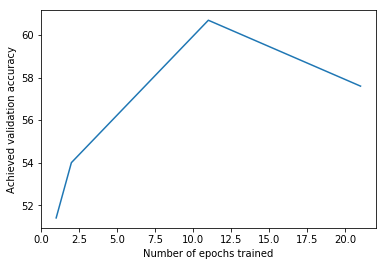

In [19]:
accList = [51.4, 54,60.7,57.6]
epochList = [1,2,11,21]
plt.plot(epochList,accList)
plt.xlabel("Number of epochs trained")
plt.ylabel("Achieved validation accuracy")
plt.show()

I'm curious how this behaves on the ladder. So let me go back to my 11 epoch model and predict labels for the test set. Make a submission file because why not. Who knows what hidden problems this might convey.

In [33]:
# load json and create model

loadedModelSubmit = loadModel('mResXX.json')
    
# load weights into new model
loadedModelSubmit.load_weights("mResXX.h5")
print("Loaded model from disk")

loadedModelSubmit.compile(optimizer = 'adam',
         loss = 'categorical_crossentropy',
         metrics = ['accuracy'])


Loaded model from disk


In [63]:
ladderTrainPaths = []
testPath = "D:/Minjino/kojesta/Data Science/Kaggle/test/"
_, _, tempF = os.walk(testPath).__next__()
temp = [testPath + tempf for tempf in tempF]
ladderTrainPaths = ladderTrainPaths + temp

def exName(path):
    head, tail = os.path.split(path)
    return tail

fnames_test = [exName(path) for path in ladderTrainPaths]

In [69]:
tic = time.time()
scoresSubmit = getPredictions2(ladderTrainPaths, loadedModelSubmit)

# s is a 1D array. Reshape. 
s = scoresSubmit.reshape((len(scoresSubmit)//10,10))

# get back the labels
labels = [backFromOneHot(sLine) for sLine in s]
toc = time.time()

print("finished this prediction in {} minutes".format((toc-tic)//60))

sub = submissionFile(fnames_test,labels) #ovo ti samo cuva u csv ali uvek zove submission.csv lol promeni to leba ti



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 30.50it/s]

Loaded batch 1 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 40.29it/s]


Loaded batch 2 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 39.90it/s]

Loaded batch 3 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 36.10it/s]

Loaded batch 4 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 36.31it/s]

Loaded batch 5 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 39.68it/s]

Loaded batch 6 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 31.58it/s]

Loaded batch 7 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 37.28it/s]

Loaded batch 8 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 28.26it/s]

Loaded batch 9 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 42.70it/s]

Loaded batch 10 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 37.23it/s]


Loaded batch 11 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 33.18it/s]

Loaded batch 12 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.36it/s]


Loaded batch 13 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 33.47it/s]

Loaded batch 14 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 33.22it/s]

Loaded batch 15 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 33.74it/s]

Loaded batch 16 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 42.48it/s]

Loaded batch 17 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 42.01it/s]

Loaded batch 18 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.85it/s]


Loaded batch 19 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 28.83it/s]

Loaded batch 20 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 35.16it/s]

Loaded batch 21 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.17it/s]

Loaded batch 22 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 33.29it/s]

Loaded batch 23 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 28.98it/s]

Loaded batch 24 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 31.41it/s]

Loaded batch 25 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 27.32it/s]

Loaded batch 26 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 34.06it/s]

Loaded batch 27 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 26.07it/s]


Loaded batch 28 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 38.52it/s]

Loaded batch 29 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.51it/s]

Loaded batch 30 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.05it/s]

Loaded batch 31 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 34.34it/s]

Loaded batch 32 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 28.90it/s]

Loaded batch 33 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 33.62it/s]

Loaded batch 34 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 34.32it/s]

Loaded batch 35 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 28.80it/s]

Loaded batch 36 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 31.80it/s]

Loaded batch 37 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 35.41it/s]

Loaded batch 38 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 28.78it/s]

Loaded batch 39 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 34.91it/s]

Loaded batch 40 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 31.31it/s]

Loaded batch 41 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 27.40it/s]

Loaded batch 42 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 33.22it/s]


Loaded batch 43 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 31.87it/s]


Loaded batch 44 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.24it/s]

Loaded batch 45 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 39.09it/s]


Loaded batch 46 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 43.36it/s]

Loaded batch 47 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.89it/s]


Loaded batch 48 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 29.53it/s]

Loaded batch 49 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 32.85it/s]

Loaded batch 50 out of 52...testing...



100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 41.46it/s]

Loaded batch 51 out of 52...testing...
Loaded last batch...testing...
finished this prediction in 34.0 minutes


Oh, so sad. Scored 0.37